In [1]:
import netneurotools.datasets
import numpy as np
from scipy.stats import pearsonr
from msapy import msa, utils as ut, plottings as pl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from network_control.utils import matrix_normalization
import networkx as nx
import logging
from copy import deepcopy
from numba import njit
from scipy.linalg import expm
from network_control.utils import matrix_normalization
from netneurotools.metrics import communicability_wei, communicability_bin

SEED = 2023
pl.set_style(font_size=8)
my_colors = ['#006685', '#3FA5C4', '#FFFFFF', '#E84653', '#BF003F']
colormap = sns.blend_palette(my_colors,as_cmap=True)

In [2]:
@njit
def simple_dynamical_system(adjacency_matrix,input_matrix):
    X = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))

    for timepoint in range(input_matrix.shape[1] - 1):
        X[:, timepoint + 1] = np.tanh(adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint])

    return X

@njit
def simple_linear_dynamical_system(adjacency_matrix,input_matrix):
    X = np.zeros((input_matrix.shape[0], input_matrix.shape[1]))

    for timepoint in range(input_matrix.shape[1] - 1):
        X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]

    return X

def find_density(connectivity):
    return np.where(connectivity!=0,1,0).sum()/connectivity.shape[0]**2

def normer(x):
    return (x - x.min()) / (x.max() - x.min())

def spectral_normalization(target_radius,connectivity):
    return connectivity * target_radius/(np.max(np.abs(np.linalg.eigvals(connectivity))))

def threshold(lower_threshold,connectivity):
    connectivity = pd.DataFrame(connectivity)
    connectivity = connectivity.fillna(0)
    lower = np.percentile(connectivity, lower_threshold)
    upper = np.percentile(connectivity, 100-lower_threshold)
    connectivity[(connectivity < upper) & (connectivity > lower)] = 0.
    return connectivity

In [3]:
netneurotools.datasets.available_connectomes()

['celegans',
 'drosophila',
 'human_func_scale033',
 'human_func_scale060',
 'human_func_scale125',
 'human_func_scale250',
 'human_func_scale500',
 'human_struct_scale033',
 'human_struct_scale060',
 'human_struct_scale125',
 'human_struct_scale250',
 'human_struct_scale500',
 'macaque_markov',
 'macaque_modha',
 'mouse',
 'rat']

In [141]:
mouse = pd.read_excel('Supplementary Table.xlsx',sheet_name='W_ipsi',index_col=0)

/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
human = netneurotools.datasets.fetch_connectome('human_struct_scale033')
# human_shuffled = human.copy()
# rng.shuffle(human_shuffled['conn'])

<AxesSubplot:>

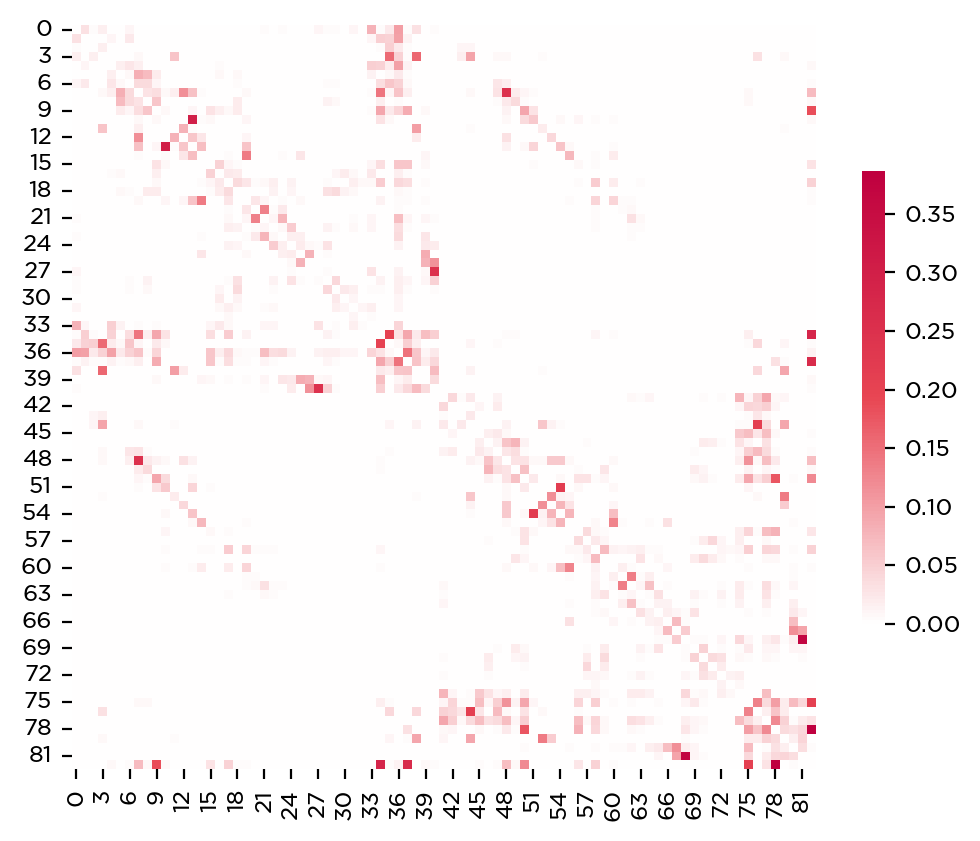

In [4]:
#connectivity = nx.to_numpy_array(nx.generators.path_graph(5,nx.DiGraph))
#connectivity[4]=0
#connectivity = np.eye(10)
#connectivity = nx.to_numpy_array(nx.generators.watts_strogatz_graph(12, 3, 0.3,seed=1))
#connectivity = nx.to_numpy_array(nx.generators.erdos_renyi_graph(6, 0.3, directed=True,seed=SEED))
connectivity = human['conn']
n_neurons = len(connectivity)
#connectivity=connectivity.T #should be transposed to have the right direction
#connectivity = connectivity * rng.uniform(-0.5,0.5,size=(n_neurons,n_neurons))
#connectivity[connectivity<0.3] = 0.
#np.fill_diagonal(connectivity,-1)
#A = matrix_normalization(connectivity, c=1, version='discrete')
connectivity = spectral_normalization(0.9,connectivity)
communication_mask = np.where(expm(connectivity)!=0,1,0)
plt.figure(dpi=200,figsize=(6,6))
sns.heatmap(connectivity,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},linewidths=0.0, linecolor='k')

In [5]:
find_density(connectivity)

0.30976919727101176

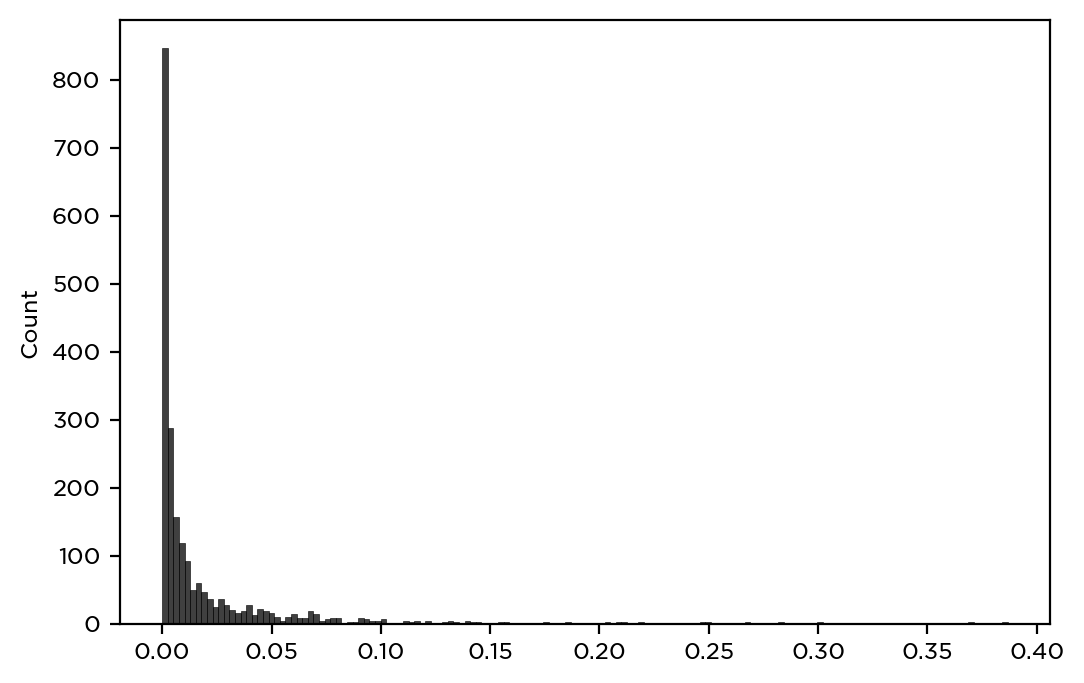

In [6]:
plt.figure(dpi=200)
sns.histplot(connectivity.flatten()[connectivity.flatten()!=0],color='k');

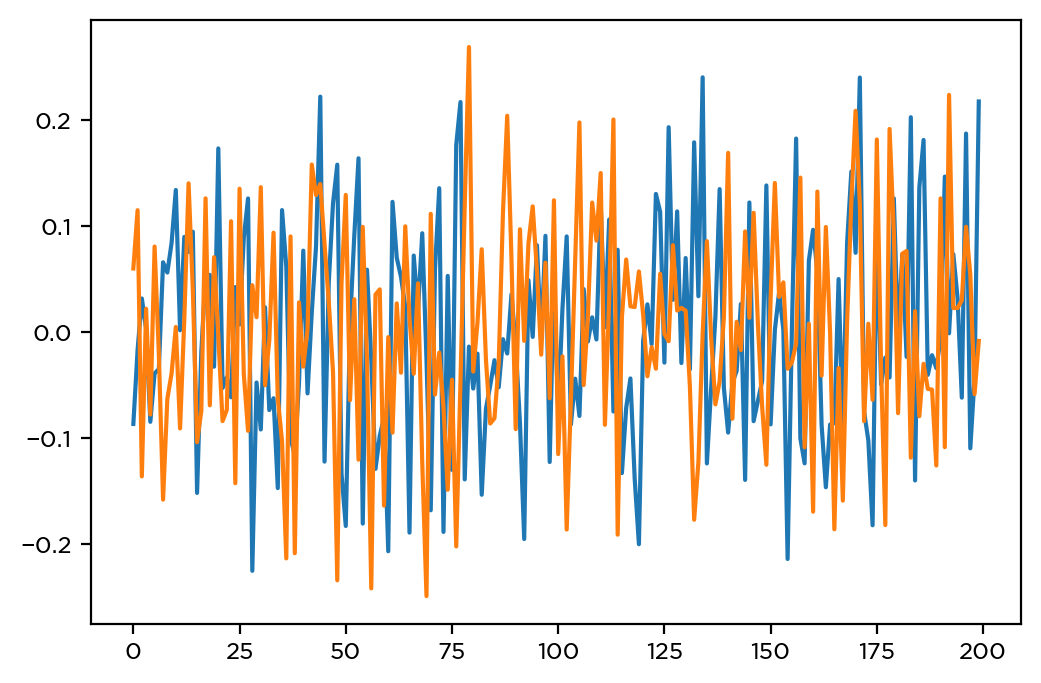

In [7]:
rng = np.random.default_rng(seed=SEED)
timesteps = 200
probability = 0.01
noise_strength = 0.1
#careers = [np.sin(np.linspace(1,i,timesteps)).squeeze() for i in range(n_neurons)]
#input = np.array(careers) #+ np.random.normal(0,0.3,(n_neurons,timesteps))

#input = rng.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons),(n_neurons,timesteps))
noise = rng.normal(0,noise_strength,(n_neurons,timesteps))
#input = gaussian_filter1d(input,4)
#input = np.zeros((n_neurons,timesteps))
pulses = rng.choice([0,1],p=[1-probability,probability],size=(n_neurons,timesteps))
#input[:,50:55] += 1
#input[1] = careers[-1]
#input = noise+pulses
input = noise
plt.figure(dpi=200)
plt.plot(input[3])
plt.plot(input[0]);

In [8]:
input.shape

(83, 200)

/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  X[:, timepoint + 1] = adjacency_matrix @ X[:, timepoint] + input_matrix[:,timepoint]
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


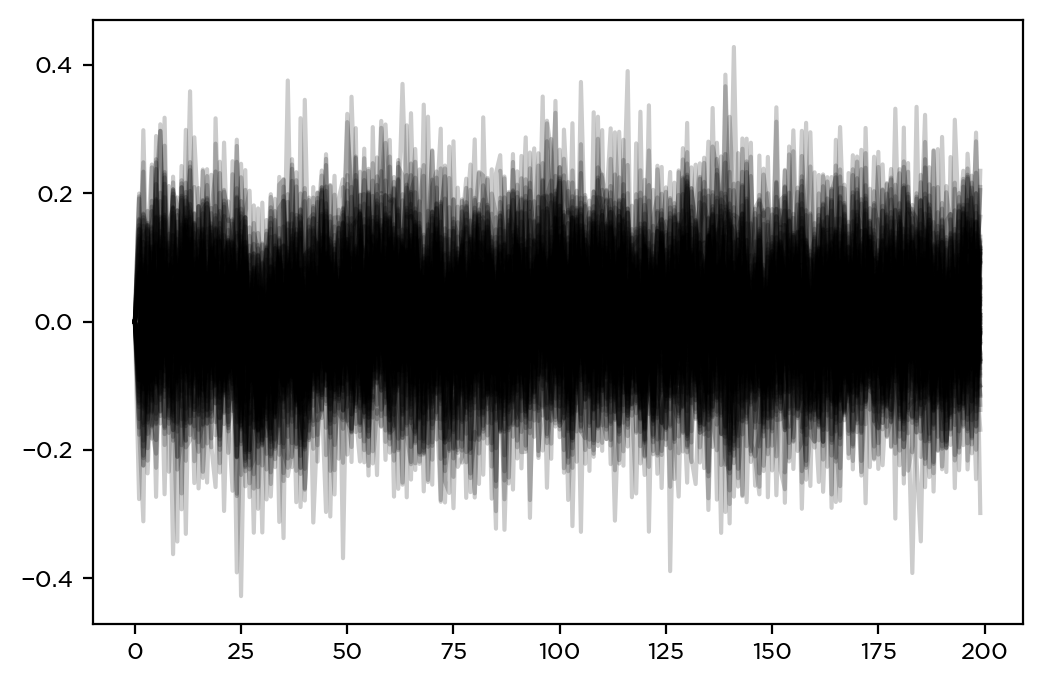

In [9]:
logging.disable(logging.WARNING)
simple_stuff = simple_linear_dynamical_system(connectivity,input)


plt.figure(dpi=200)
alphas = np.linspace(0.2,1,len(connectivity))
# for i in range(len(connectivity)):
#     plt.plot(simple_stuff.T[:,i],label=i,alpha=0.2,color='k')
# plt.plot(simple_stuff.T[:,50],alpha=1,color='k')
# plt.plot(simple_stuff.T[:,2],alpha=1,color='r');
plt.plot(simple_stuff.T,alpha=0.2,color='k');


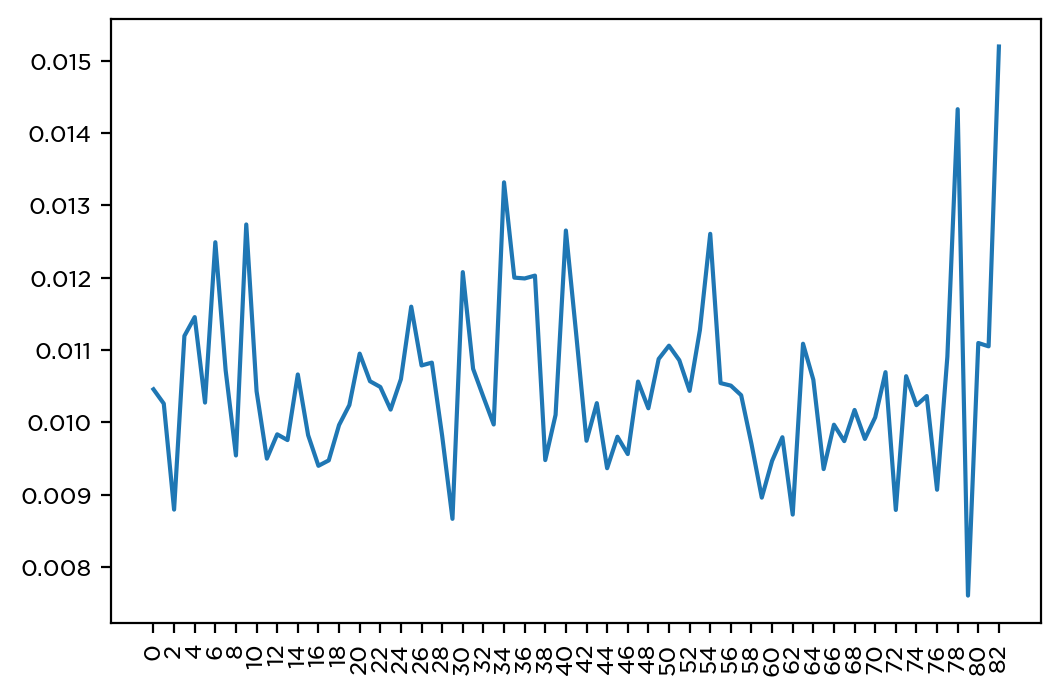

In [10]:
plt.figure(dpi=200)
plt.plot(simple_stuff.var(axis=1))
plt.xticks(np.arange(0,len(connectivity),2),rotation=90);

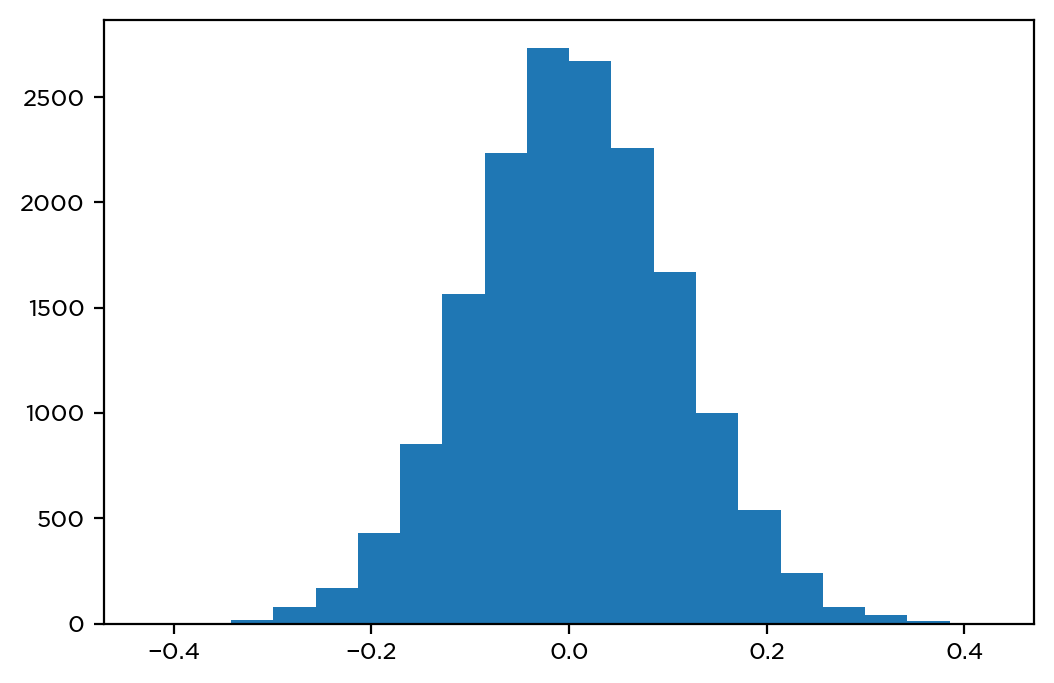

In [11]:
plt.figure(dpi=200)
plt.hist(simple_stuff.flatten(),bins=20);

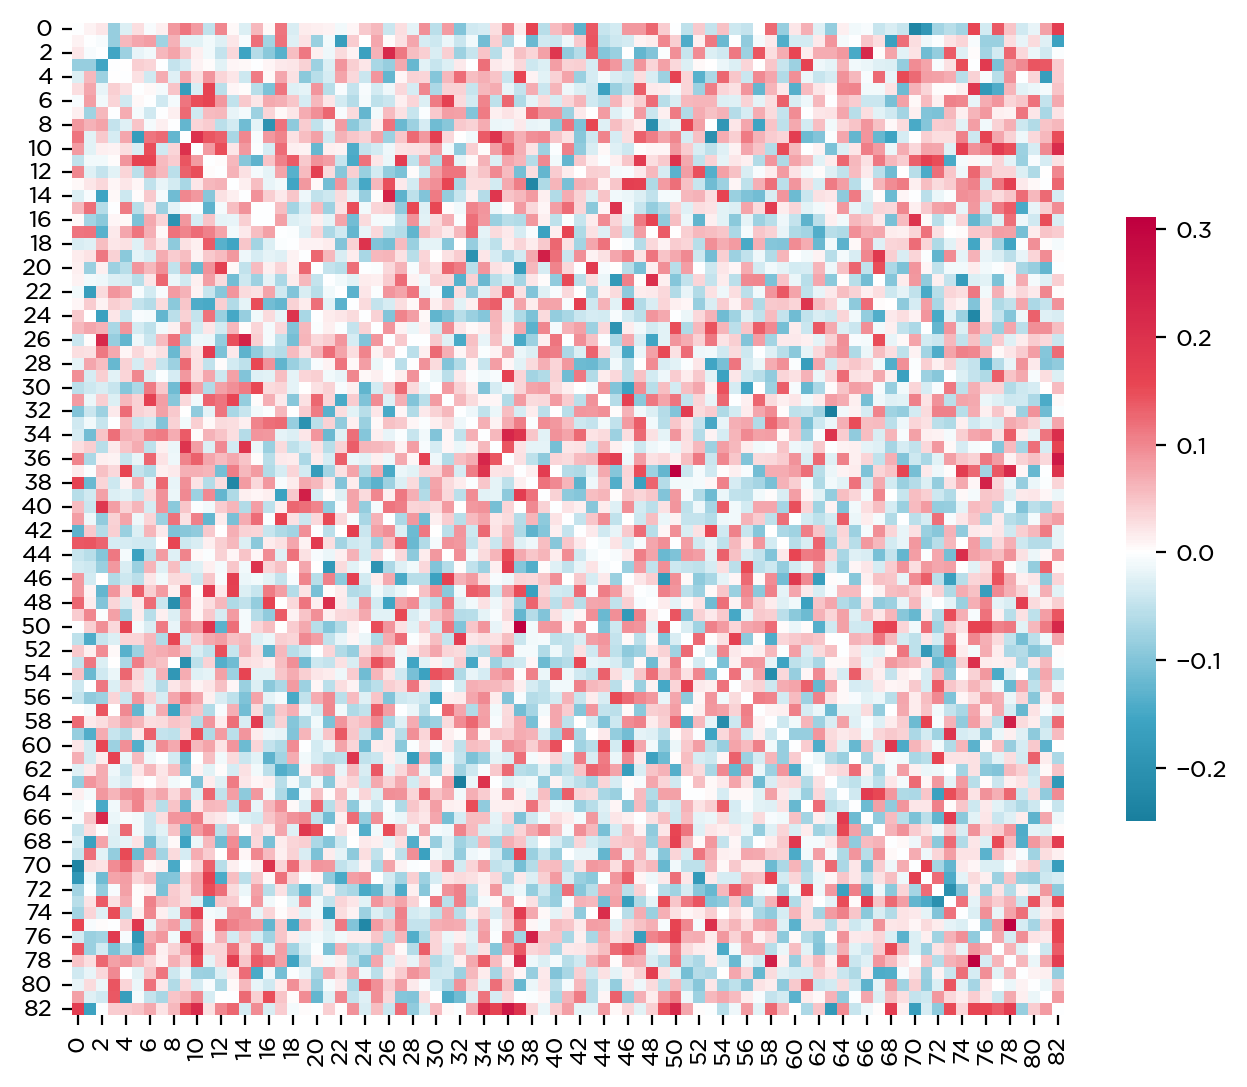

In [12]:
plt.figure(figsize=(8,8),dpi=200)
fc = np.corrcoef(simple_stuff)
np.fill_diagonal(fc,0.)
sns.heatmap(fc,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},linewidths=0., linecolor='k');

In [13]:
def lesion_simple_nodes(complements, network, index,input):

    # if len(complements) == len(network) - 1:
    #     return np.zeros(input.shape[1]).squeeze()
    #     #return 0.0
    lesioned_network = deepcopy(network)
    for target in complements:
        lesioned_network[:,target] = 0.0
        lesioned_network[target,:] = 0.0

    dynamics = simple_linear_dynamical_system(lesioned_network,input)
    lesioned_signal = dynamics[index,:]
    return lesioned_signal


In [14]:
lesion_params = {'network': connectivity, 'input': input}
ci_mat = msa.estimate_causal_influences(elements=list(range(n_neurons)),
                                        objective_function=lesion_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=-1)

working on node number 0 from 83 nodes.


Playing the games:   0%|          | 16/78903 [00:00<19:25, 67.71it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 1 from 83 nodes.


Playing the games:   0%|          | 16/78879 [00:00<25:04, 52.43it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 2 from 83 nodes.


Playing the games:   0%|          | 16/78877 [00:00<30:16, 43.42it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 3 from 83 nodes.


Playing the games:   0%|          | 16/78886 [00:00<29:15, 44.93it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 4 from 83 nodes.


Playing the games:   0%|          | 16/78873 [00:00<31:42, 41.45it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 5 from 83 nodes.


Playing the games:   0%|          | 16/78867 [00:00<29:41, 44.27it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 6 from 83 nodes.


Playing the games:   0%|          | 16/78866 [00:00<28:38, 45.88it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on conti

working on node number 7 from 83 nodes.


Playing the games:   0%|          | 16/78862 [00:00<30:03, 43.72it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 8 from 83 nodes.


Playing the games:   0%|          | 16/78896 [00:00<31:28, 41.78it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 9 from 83 nodes.


Playing the games:   0%|          | 16/78884 [00:00<39:40, 33.13it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 10 from 83 nodes.


Playing the games:   0%|          | 16/78870 [00:00<36:22, 36.13it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 11 from 83 nodes.


Playing the games:   0%|          | 16/78891 [00:00<31:23, 41.89it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 12 from 83 nodes.


Playing the games:   0%|          | 16/78885 [00:00<33:41, 39.01it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 13 from 83 nodes.


Playing the games:   0%|          | 16/78871 [00:00<31:26, 41.80it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProje

working on node number 14 from 83 nodes.


Playing the games:   0%|          | 16/78886 [00:00<31:22, 41.89it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 15 from 83 nodes.


Playing the games:   0%|          | 16/78863 [00:00<30:29, 43.10it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 16 from 83 nodes.


Playing the games:   0%|          | 16/78892 [00:00<33:35, 39.13it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 17 from 83 nodes.


Playing the games:   0%|          | 16/78887 [00:00<28:28, 46.16it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 18 from 83 nodes.


Playing the games:   0%|          | 16/78884 [00:00<30:15, 43.44it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 19 from 83 nodes.


Playing the games:   0%|          | 16/78863 [00:00<35:04, 37.47it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 20 from 83 nodes.


Playing the games:   0%|          | 16/78890 [00:00<27:41, 47.47it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 21 from 83 nodes.


Playing the games:   0%|          | 16/78875 [00:00<33:24, 39.34it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 22 from 83 nodes.


Playing the games:   0%|          | 16/78870 [00:00<27:38, 47.53it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 23 from 83 nodes.


Playing the games:   0%|          | 16/78884 [00:00<29:45, 44.16it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 24 from 83 nodes.


Playing the games:   0%|          | 16/78896 [00:00<28:15, 46.53it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 25 from 83 nodes.


Playing the games:   0%|          | 16/78889 [00:00<31:35, 41.61it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 26 from 83 nodes.


Playing the games:   0%|          | 16/78910 [00:00<28:50, 45.60it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 27 from 83 nodes.


Playing the games:   0%|          | 16/78897 [00:00<29:55, 43.92it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 28 from 83 nodes.


Playing the games:   0%|          | 16/78884 [00:00<31:20, 41.94it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 29 from 83 nodes.


Playing the games:   0%|          | 16/78895 [00:00<28:31, 46.09it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 30 from 83 nodes.


Playing the games:   0%|          | 16/78880 [00:00<28:14, 46.55it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 31 from 83 nodes.


Playing the games:   0%|          | 16/78867 [00:00<30:29, 43.10it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 32 from 83 nodes.


Playing the games:   0%|          | 16/78884 [00:00<29:59, 43.83it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 33 from 83 nodes.


Playing the games:   0%|          | 16/78888 [00:00<29:31, 44.53it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 34 from 83 nodes.


Playing the games:   0%|          | 16/78878 [00:00<33:00, 39.81it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 35 from 83 nodes.


Playing the games:   0%|          | 16/78885 [00:00<33:48, 38.88it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 36 from 83 nodes.


Playing the games:   0%|          | 16/78890 [00:00<28:27, 46.19it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 37 from 83 nodes.


Playing the games:   0%|          | 16/78864 [00:00<30:01, 43.77it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 38 from 83 nodes.


Playing the games:   0%|          | 16/78903 [00:00<33:08, 39.67it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 39 from 83 nodes.


Playing the games:   0%|          | 16/78872 [00:00<31:44, 41.40it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 40 from 83 nodes.


Playing the games:   0%|          | 16/78880 [00:00<33:08, 39.66it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 41 from 83 nodes.


Playing the games:   0%|          | 16/78891 [00:00<32:28, 40.47it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 42 from 83 nodes.


Playing the games:   0%|          | 16/78871 [00:00<27:47, 47.28it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 43 from 83 nodes.


Playing the games:   0%|          | 16/78861 [00:00<33:51, 38.82it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d,

working on node number 44 from 83 nodes.


Playing the games:   0%|          | 16/78864 [00:00<28:53, 45.48it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 45 from 83 nodes.


Playing the games:   0%|          | 16/78900 [00:00<30:00, 43.81it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 46 from 83 nodes.


Playing the games:   0%|          | 16/78890 [00:00<32:52, 39.98it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 47 from 83 nodes.


Playing the games:   0%|          | 16/78882 [00:00<30:55, 42.51it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 48 from 83 nodes.


Playing the games:   0%|          | 16/78892 [00:00<30:39, 42.88it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 49 from 83 nodes.


Playing the games:   0%|          | 16/78879 [00:00<29:08, 45.09it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 50 from 83 nodes.


Playing the games:   0%|          | 16/78912 [00:00<30:07, 43.65it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 51 from 83 nodes.


Playing the games:   0%|          | 16/78890 [00:00<32:11, 40.84it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 52 from 83 nodes.


Playing the games:   0%|          | 16/78886 [00:00<29:08, 45.10it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 53 from 83 nodes.


Playing the games:   0%|          | 16/78891 [00:00<29:15, 44.93it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 54 from 83 nodes.


Playing the games:   0%|          | 16/78884 [00:00<33:00, 39.82it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 55 from 83 nodes.


Playing the games:   0%|          | 16/78860 [00:00<29:25, 44.66it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 56 from 83 nodes.


Playing the games:   0%|          | 16/78871 [00:00<29:48, 44.10it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 57 from 83 nodes.


Playing the games:   0%|          | 16/78856 [00:00<31:05, 42.27it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 58 from 83 nodes.


Playing the games:   0%|          | 16/78885 [00:00<25:08, 52.27it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 59 from 83 nodes.


Playing the games:   0%|          | 16/78888 [00:00<27:02, 48.60it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 60 from 83 nodes.


Playing the games:   0%|          | 16/78881 [00:00<33:20, 39.43it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 61 from 83 nodes.


Playing the games:   0%|          | 16/78884 [00:00<32:09, 40.88it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 62 from 83 nodes.


Playing the games:   0%|          | 16/78890 [00:00<29:00, 45.33it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 63 from 83 nodes.


Playing the games:   0%|          | 16/78867 [00:00<30:57, 42.46it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 64 from 83 nodes.


Playing the games:   0%|          | 16/78864 [00:00<30:42, 42.79it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 65 from 83 nodes.


Playing the games:   0%|          | 16/78906 [00:00<28:46, 45.69it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 66 from 83 nodes.


Playing the games:   0%|          | 16/78882 [00:00<28:51, 45.56it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 67 from 83 nodes.


Playing the games:   0%|          | 16/78879 [00:00<32:29, 40.44it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 68 from 83 nodes.


Playing the games:   0%|          | 16/78901 [00:00<32:15, 40.77it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 69 from 83 nodes.


Playing the games:   0%|          | 16/78865 [00:00<31:51, 41.25it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on conti

working on node number 70 from 83 nodes.


Playing the games:   0%|          | 16/78860 [00:00<28:56, 45.39it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 71 from 83 nodes.


Playing the games:   0%|          | 16/78872 [00:00<28:50, 45.56it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 72 from 83 nodes.


Playing the games:   0%|          | 16/78887 [00:00<29:16, 44.89it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 73 from 83 nodes.


Playing the games:   0%|          | 16/78889 [00:00<31:08, 42.22it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 74 from 83 nodes.


Playing the games:   0%|          | 16/78891 [00:00<30:45, 42.73it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 75 from 83 nodes.


Playing the games:   0%|          | 16/78872 [00:00<31:22, 41.88it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 76 from 83 nodes.


Playing the games:   0%|          | 16/78876 [00:00<29:18, 44.85it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProje

working on node number 77 from 83 nodes.


Playing the games:   0%|          | 16/78886 [00:00<31:37, 41.57it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

working on node number 78 from 83 nodes.


Playing the games:   0%|          | 16/78906 [00:00<30:52, 42.59it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, 

working on node number 79 from 83 nodes.


Playing the games:   0%|          | 16/78877 [00:00<37:12, 35.32it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 80 from 83 nodes.


Playing the games:   0%|          | 16/78886 [00:00<26:45, 49.13it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 81 from 83 nodes.


Playing the games:   0%|          | 16/78884 [00:00<31:06, 42.26it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: N

working on node number 82 from 83 nodes.


Playing the games:   0%|          | 16/78890 [00:00<32:10, 40.87it/s]/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/numba/core/typing/npydecl.py:965: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/tmp/ipykernel_5019/1459761382.py:15: NumbaPerformanceWarning: '@' is faster on con

In [15]:
cmodes = ci_mat.groupby(level=0).var().fillna(0)


In [16]:
cmodes

0             1             2             3             4   \
0   0.000000e+00  1.158884e-05  2.058531e-07  3.391434e-06  7.088370e-07   
1   1.144454e-05  0.000000e+00  5.984265e-08  4.509273e-07  1.839199e-06   
2   2.379414e-07  7.357649e-08  0.000000e+00  3.249606e-06  4.228364e-08   
3   3.437032e-06  4.553737e-07  2.811661e-06  0.000000e+00  2.411084e-07   
4   6.585761e-07  1.662577e-06  3.124433e-08  2.189844e-07  0.000000e+00   
..           ...           ...           ...           ...           ...   
78  5.723393e-08  2.958538e-07  2.320715e-08  3.256088e-07  3.570920e-07   
79  3.207532e-08  6.752755e-09  7.569426e-09  2.421930e-06  6.873677e-09   
80  4.941634e-10  2.450586e-09  1.867071e-10  4.469473e-09  2.618312e-09   
81  6.138153e-10  2.718297e-09  2.540958e-10  9.174621e-09  2.769052e-09   
82  3.246036e-07  1.864415e-06  1.167692e-07  1.111562e-06  2.906443e-06   

              5             6             7             8             9   ...  \
0   5.082401e-08  1.326928e-06  2.223602e-07  5.932904e-09  1.702739e-07  ...   
1   5.275411e-08  6.268463e-06  7.322315e-07  1.832678e-08  5.381117e-07  ...   
2   4.416656e-09  6.774847e-08  6.103802e-08  1.089753e-09  4.805078e-08  ...   
3   4.038134e-08  5.275109e-07  1.299806e-06  1.046950e-08  3.154967e-07  ...   
4   3.317988e-06  8.592563e-06  3.966918e-06  5.320133e-08  7.187971e-07  ...   
..           ...           ...           ...           ...           ...  ...   
78  2.577092e-07  5.064839e-07  1.124701e-05  3.090116e-07  3.149042e-05  ...   
79  3.685219e-09  1.451155e-08  1.343223e-07  2.957720e-09  1.499421e-07  ...   
80  2.221909e-09  5.422229e-09  9.285437e-08  2.960620e-09  1.420751e-07  ...   
81  2.407843e-09  5.000925e-09  9.410183e-08  2.691469e-09  1.345463e-07  ...   
82  1.238821e-06  2.860401e-06  8.361463e-05  1.773634e-06  4.326382e-04  ...   

              73            74            75            76            77  \
0   2.599477e-13  2.818229e-10  2.671817e-08  2.077080e-08  6.886817e-09   
1   8.596711e-13  9.750644e-10  1.172618e-07  2.388402e-08  2.764671e-08   
2   1.354145e-13  2.517734e-10  1.317763e-08  7.991428e-08  5.864623e-09   
3   1.621209e-12  5.987784e-09  3.194090e-07  1.052464e-05  1.587283e-07   
4   1.142832e-12  1.045616e-09  1.369305e-07  1.827214e-08  2.802521e-08   
..           ...           ...           ...           ...           ...   
78  6.313720e-10  1.002737e-06  1.340692e-04  3.280373e-05  1.617454e-04   
79  1.249136e-11  9.114625e-08  3.667297e-06  5.568458e-06  2.121967e-05   
80  1.776923e-11  2.283232e-08  4.415477e-05  3.581187e-07  5.067421e-07   
81  6.343767e-11  7.172384e-07  1.482665e-05  2.598453e-07  4.318827e-06   
82  7.281312e-10  6.269174e-07  4.443746e-04  9.437646e-06  2.945672e-05   

              78            79            80            81            82  
0   8.971091e-08  1.958464e-08  4.915340e-10  7.449847e-10  5.074170e-07  
1   4.304316e-07  3.966341e-09  2.003618e-09  2.700408e-09  2.203490e-06  
2   4.577403e-08  5.937363e-09  2.424453e-10  3.574379e-10  1.770727e-07  
3   4.736414e-07  1.527564e-06  5.336429e-09  8.988119e-09  1.696952e-06  
4   5.579146e-07  3.879692e-09  2.997213e-09  3.428333e-09  3.220445e-06  
..           ...           ...           ...           ...           ...  
78  0.000000e+00  9.886867e-06  1.248342e-05  1.795083e-05  1.740360e-03  
79  1.546972e-05  0.000000e+00  2.821072e-06  2.005480e-05  2.865618e-06  
80  1.334068e-05  1.869926e-06  0.000000e+00  1.206274e-05  3.673614e-06  
81  2.065363e-05  1.463360e-05  1.358766e-05  0.000000e+00  3.227733e-06  
82  2.071436e-03  1.242350e-06  3.087166e-06  2.547022e-06  0.000000e+00  

[83 rows x 83 columns]

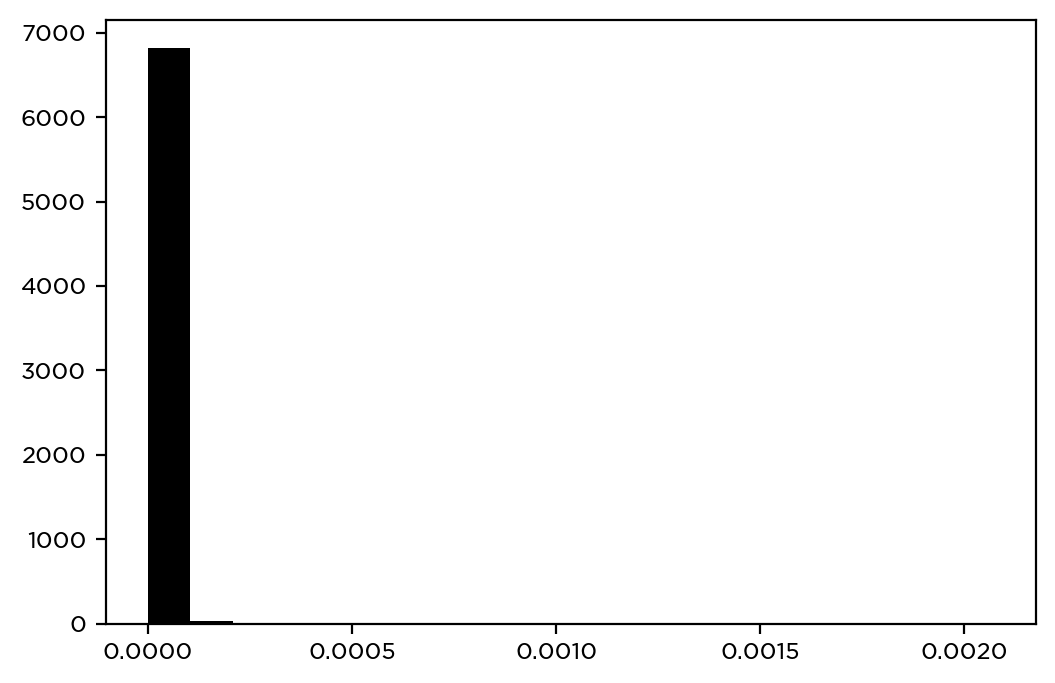

In [17]:
plt.figure(dpi=200)
plt.hist(cmodes.values.flatten(),color='k',bins=20);

/tmp/ipykernel_5019/1758716670.py:2: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.nan_to_num(np.log(cmodes.values.flatten()),neginf=0),color='k',bins=20);


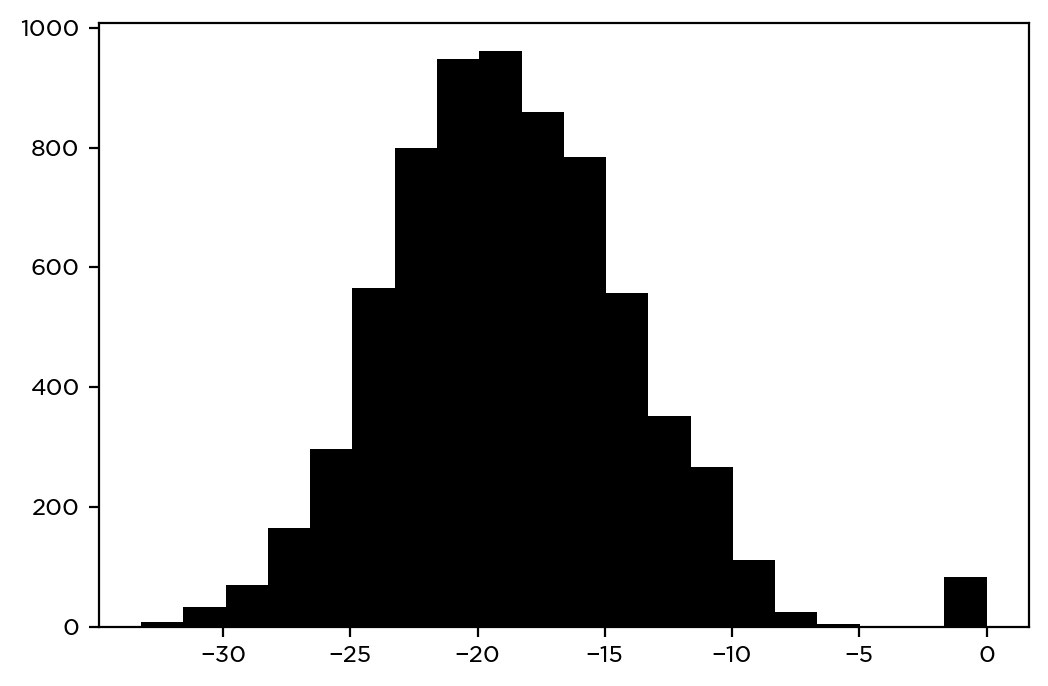

In [18]:
plt.figure(dpi=200)
plt.hist(np.nan_to_num(np.log(cmodes.values.flatten()),neginf=0),color='k',bins=20);

In [541]:
cmodes.values.flatten().shape

(6889,)

In [19]:
cmodes = cmodes.set_axis(human.labels,axis=1)
cmodes = cmodes.set_axis(human.labels,axis=0)


In [20]:
connectivitypd = pd.DataFrame(connectivity,columns=human.labels,index=human.labels,)

<AxesSubplot:>

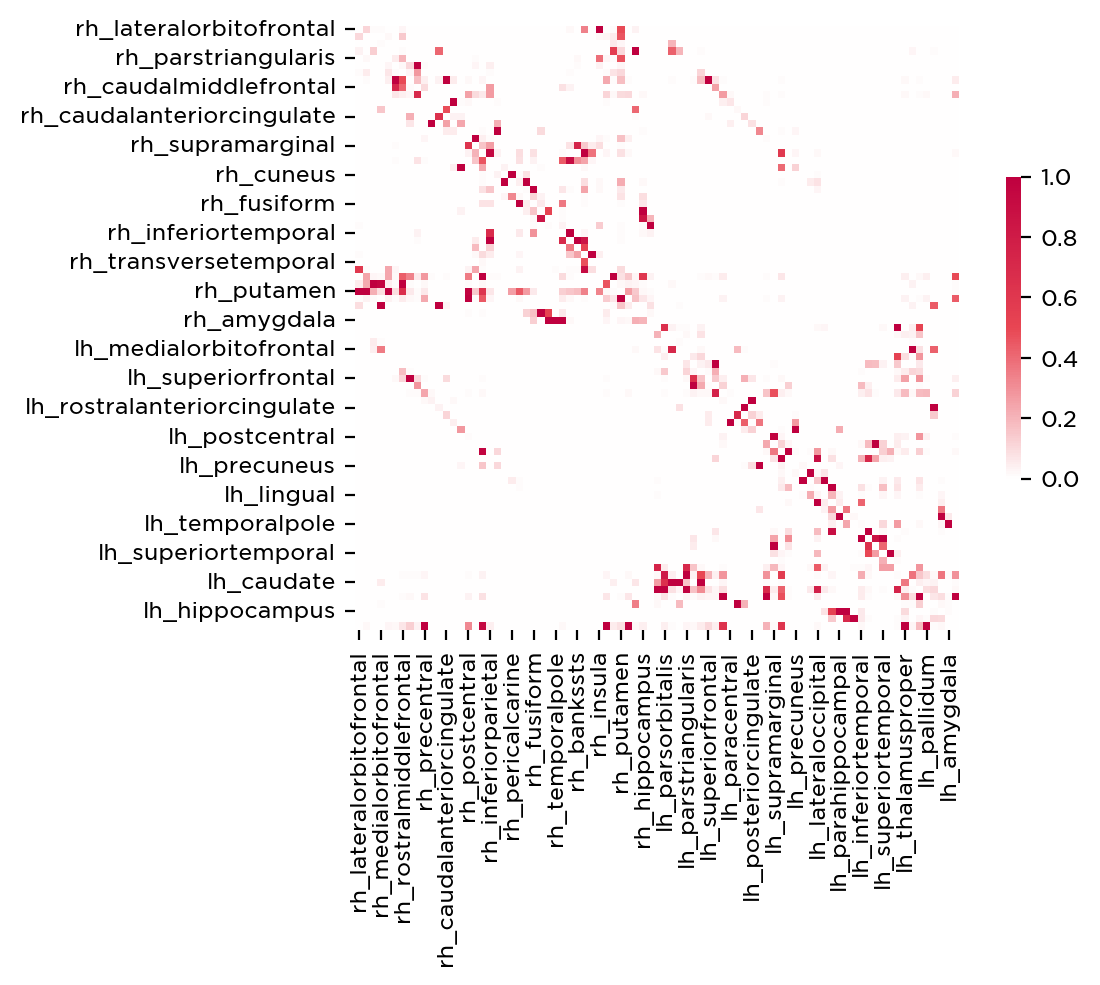

In [22]:
plt.figure(dpi=200)
sns.heatmap(normer(cmodes),center=0,square=True,cmap=colormap,cbar_kws={"shrink": .5},linewidths=0., linecolor='k')

In [630]:
thresholdedcm = threshold(5,normer(cmodes))
thresholdedsc = threshold(5,normer(connectivitypd))

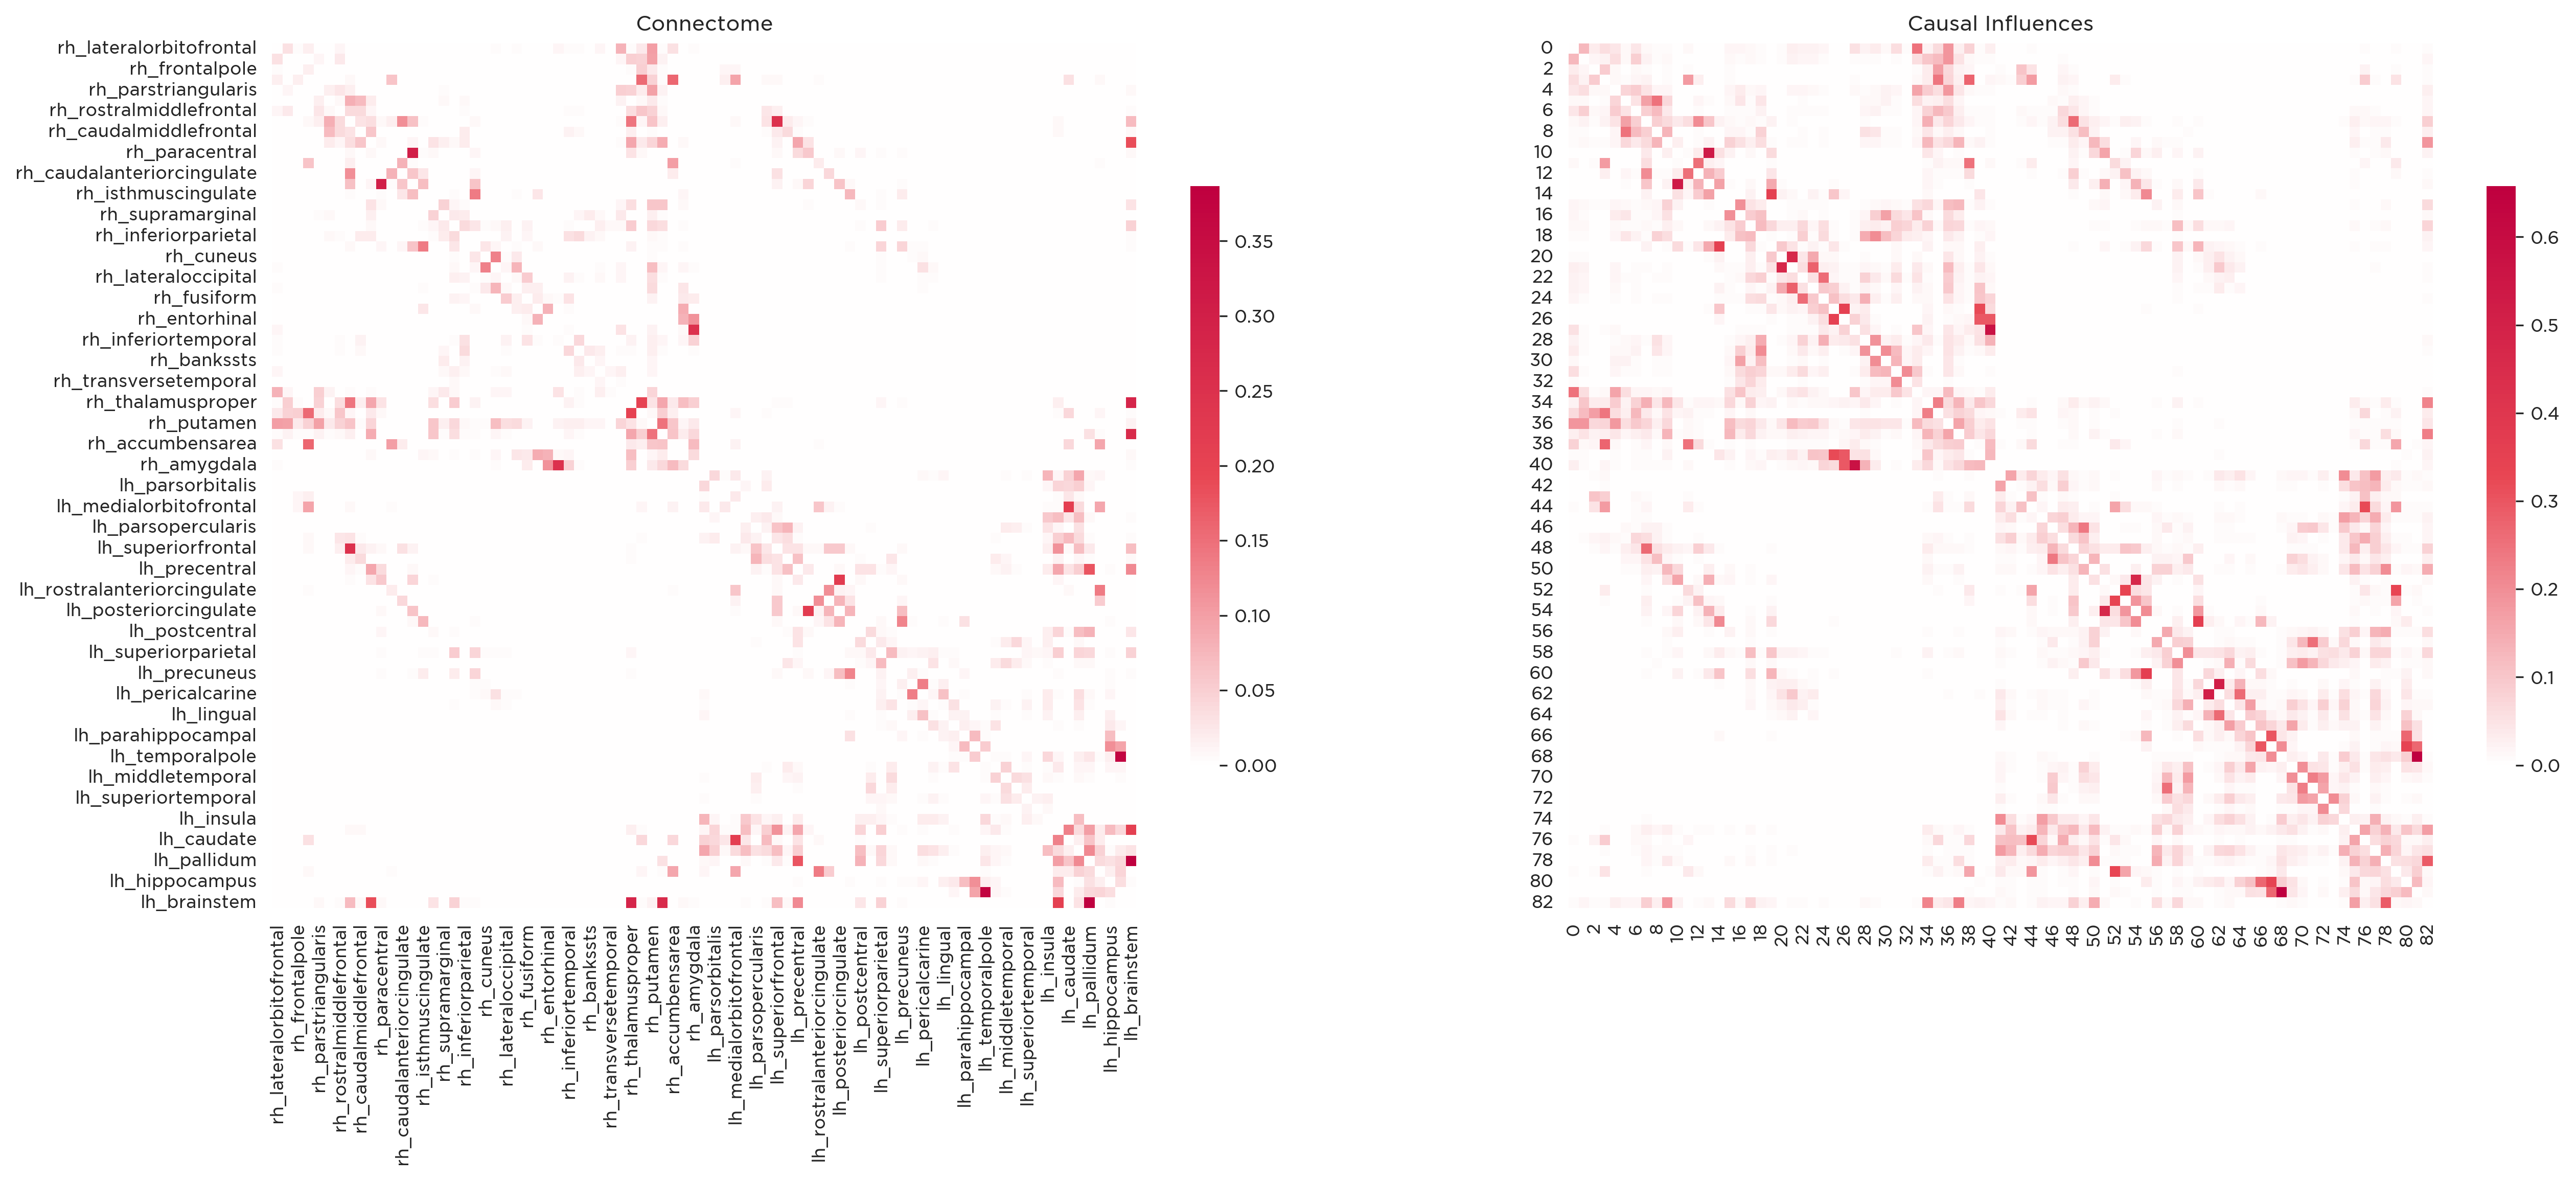

In [635]:
fig,axes = plt.subplot_mosaic(
    [['A','B']],figsize=(20,10),dpi=300)
sns.heatmap(connectivitypd,square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},ax=axes['A'],linewidths=0., linecolor='k')
sns.heatmap(commun,square=True,
            cmap=colormap,center=0,cbar_kws={"shrink": .5},ax=axes['B'],linewidths=0., linecolor='k')
axes['A'].title.set_text('Connectome')
axes['B'].title.set_text('Causal Influences')

In [ ]:
logcmodes = np.nan_to_num(np.log(cmodes.values.flatten()),neginf=0)
logconnectivity = np.nan_to_num(np.log(connectivitypd.values.flatten()),neginf=0)
commun = communicability_wei(connectivity)
logcommun = np.nan_to_num(np.log(commun.flatten()),neginf=0)

<AxesSubplot:>

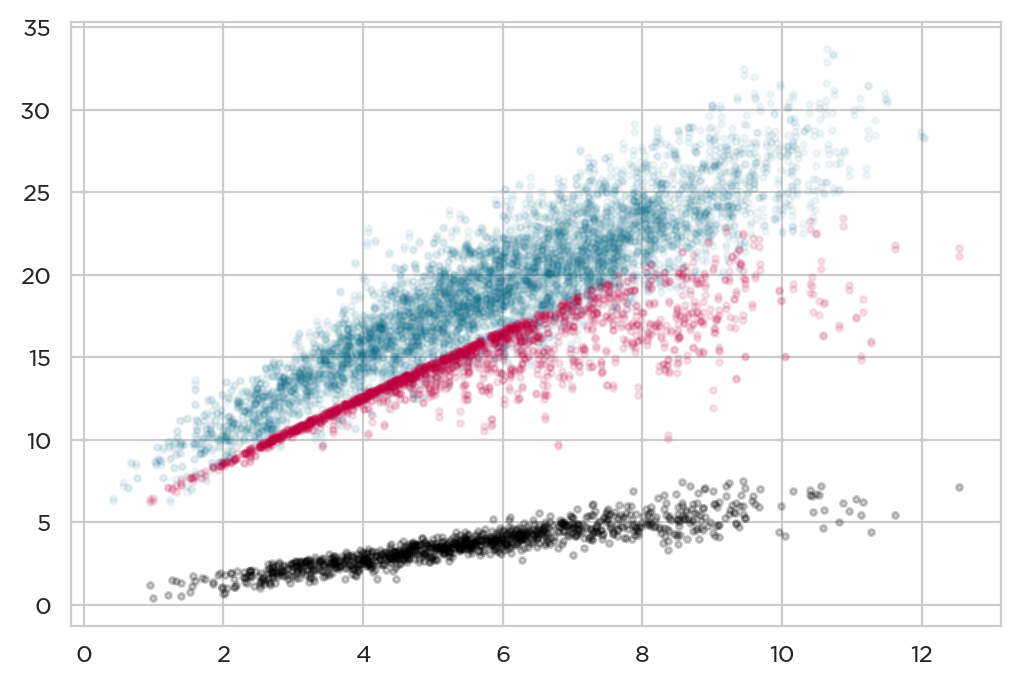

In [613]:
plt.figure(dpi=200)

sns.regplot(x=np.abs(logcommun[logcommun!=0]),y=np.abs(logcmodes[logcmodes!=0]),color=my_colors[0],scatter_kws={'alpha':0.05,'s':5},fit_reg=False) #blue
sns.regplot(x=np.abs(logconnectivity[logconnectivity!=0]),y=np.abs(logcmodes[logconnectivity!=0]),color=my_colors[-1],scatter_kws={'alpha':0.1,'s':5},fit_reg=False)
sns.regplot(x=np.abs(logconnectivity[logconnectivity!=0]),y=np.abs(logcommun[logconnectivity!=0]),color='k',scatter_kws={'alpha':0.1,'s':5},fit_reg=False)

<AxesSubplot:>

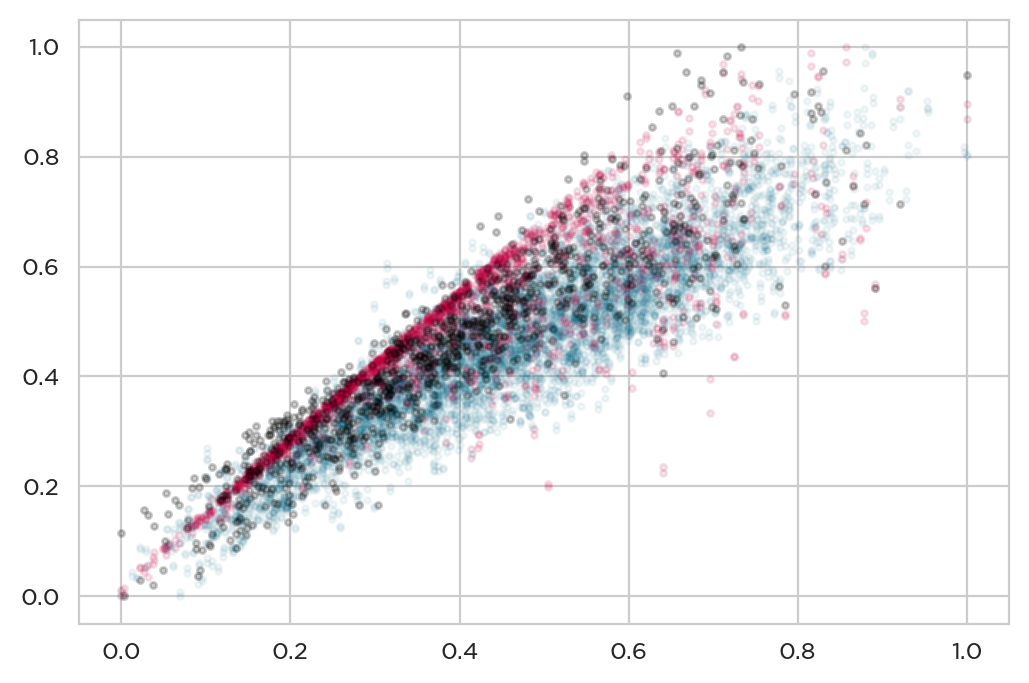

In [612]:
plt.figure(dpi=200)

sns.regplot(x=normer(np.abs(logcommun[logcommun!=0])),y=normer(np.abs(logcmodes[logcmodes!=0])),color=my_colors[0],scatter_kws={'alpha':0.05,'s':5},fit_reg=False) #blue
sns.regplot(x=normer(np.abs(logconnectivity[logconnectivity!=0])),y=normer(np.abs(logcmodes[logconnectivity!=0])),color=my_colors[-1],scatter_kws={'alpha':0.1,'s':5},fit_reg=False)
sns.regplot(x=normer(np.abs(logconnectivity[logconnectivity!=0])),y=normer(np.abs(logcommun[logconnectivity!=0])),color='k',scatter_kws={'alpha':0.1,'s':5},fit_reg=False)


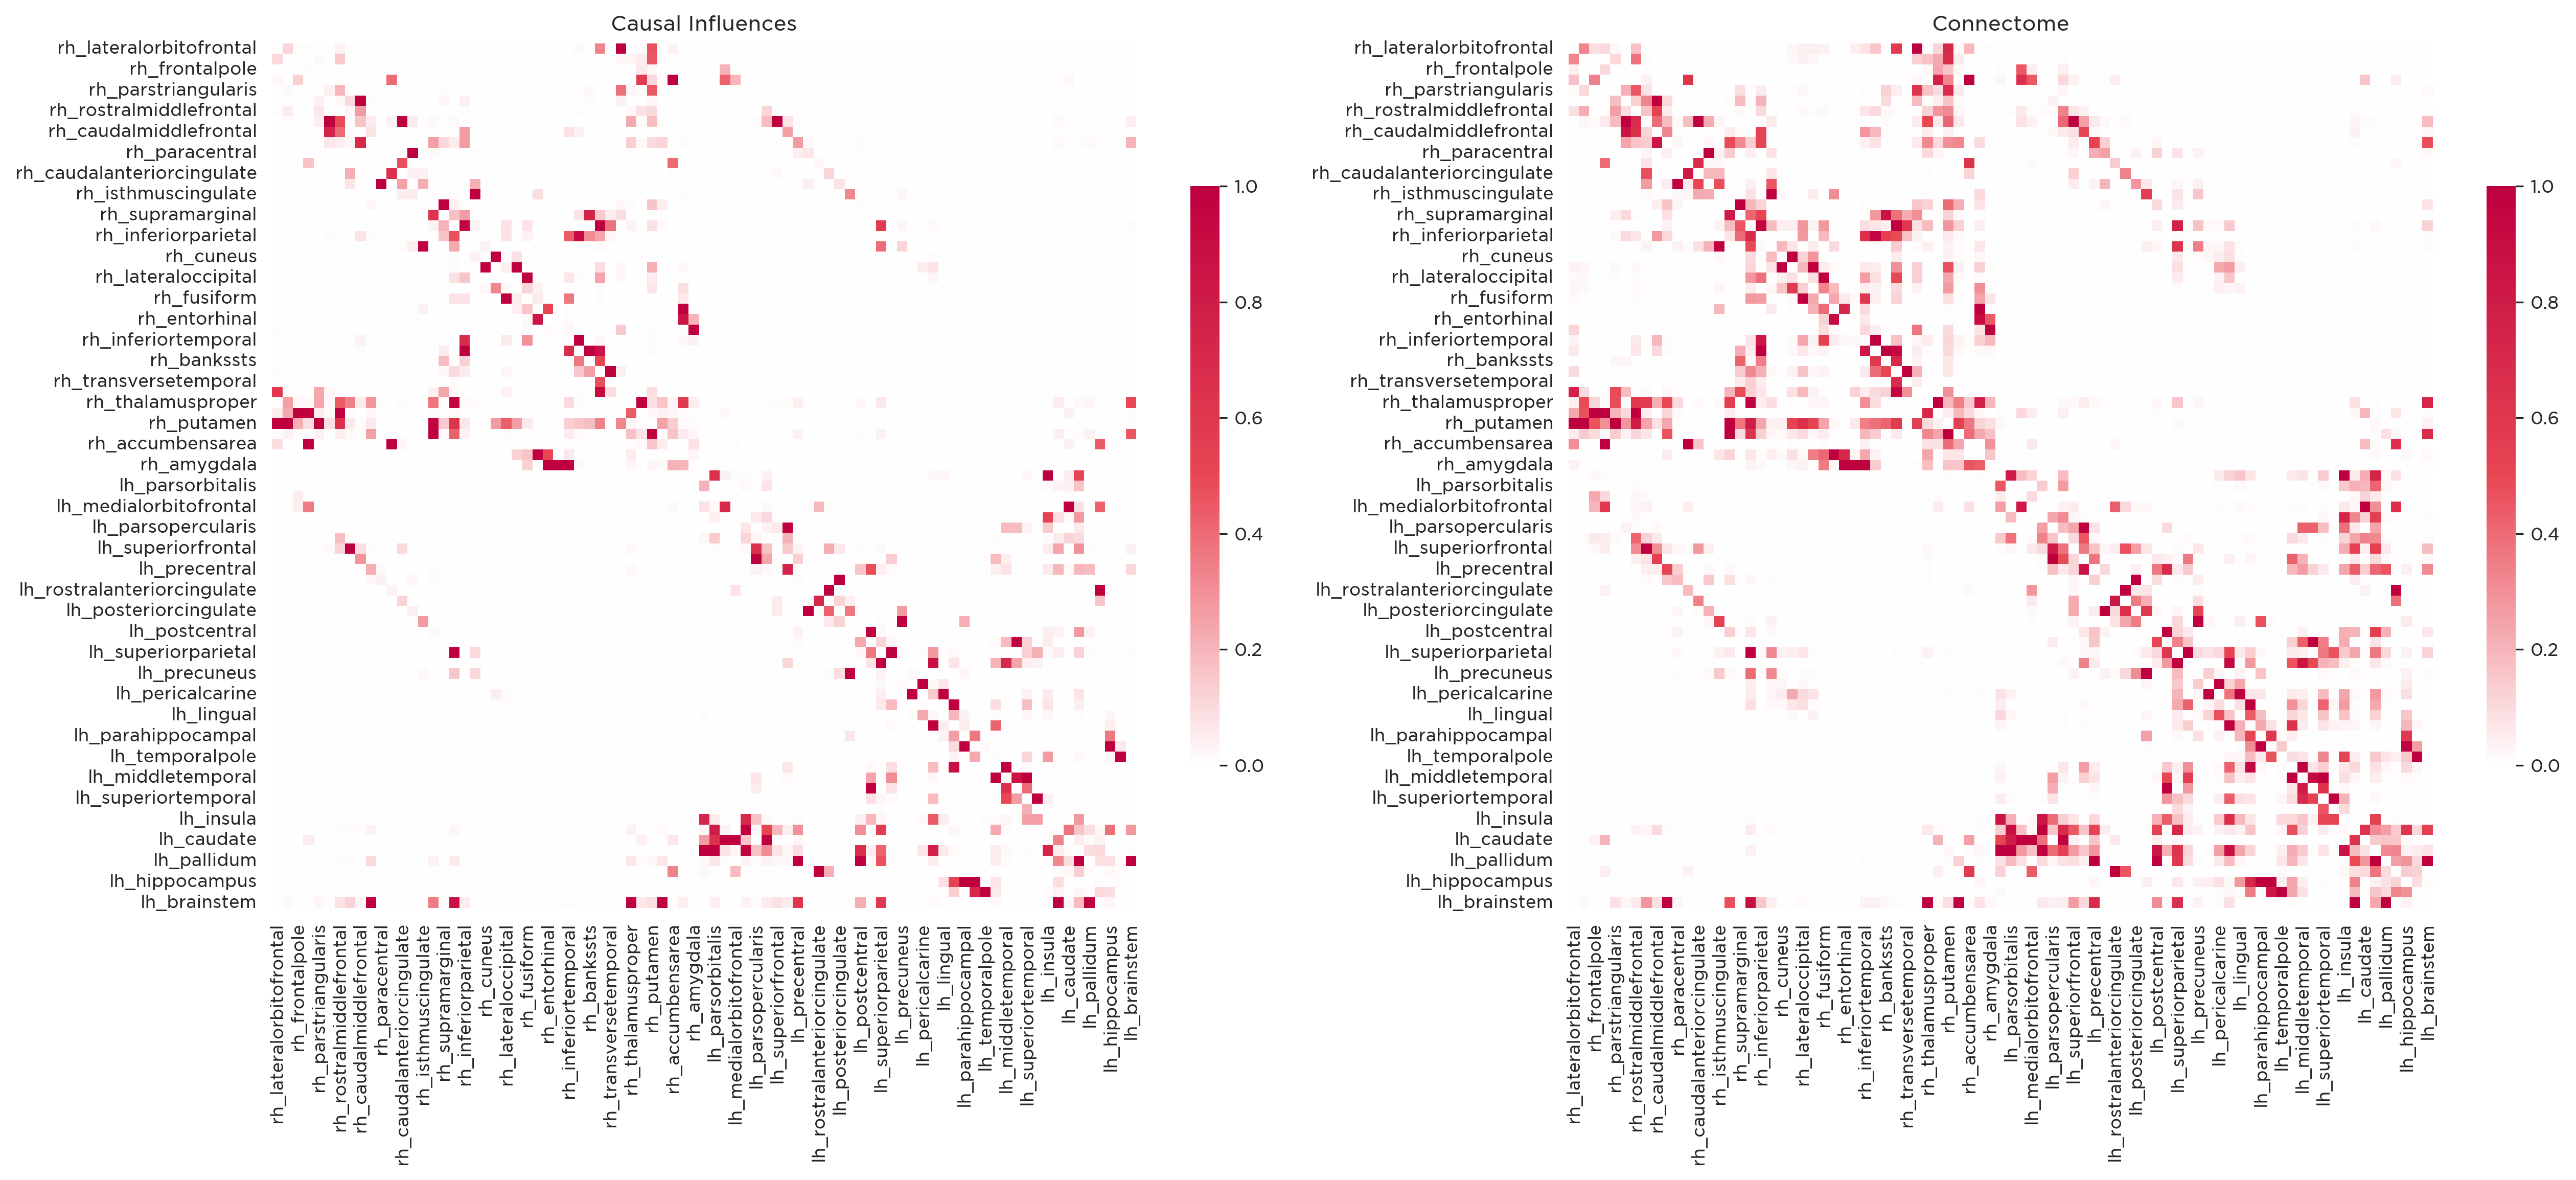

In [600]:
fig,axes = plt.subplot_mosaic(
    [['A','B']],figsize=(20,10),dpi=300)
sns.heatmap(normer(cmodes),square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},ax=axes['A'],linewidths=0., linecolor='k')
sns.heatmap(normer(connectivitypd),square=True,
            cmap=colormap,center=0,cbar_kws={"shrink": .5},ax=axes['B'],linewidths=0., linecolor='k')
axes['A'].title.set_text('Causal Influences')
axes['B'].title.set_text('Connectome')

In [655]:
import scipy.io
mat = scipy.io.loadmat('/home/kayson/Downloads/Individual_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
consmat = scipy.io.loadmat('/home/kayson/Downloads/Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)

<AxesSubplot:label='B'>

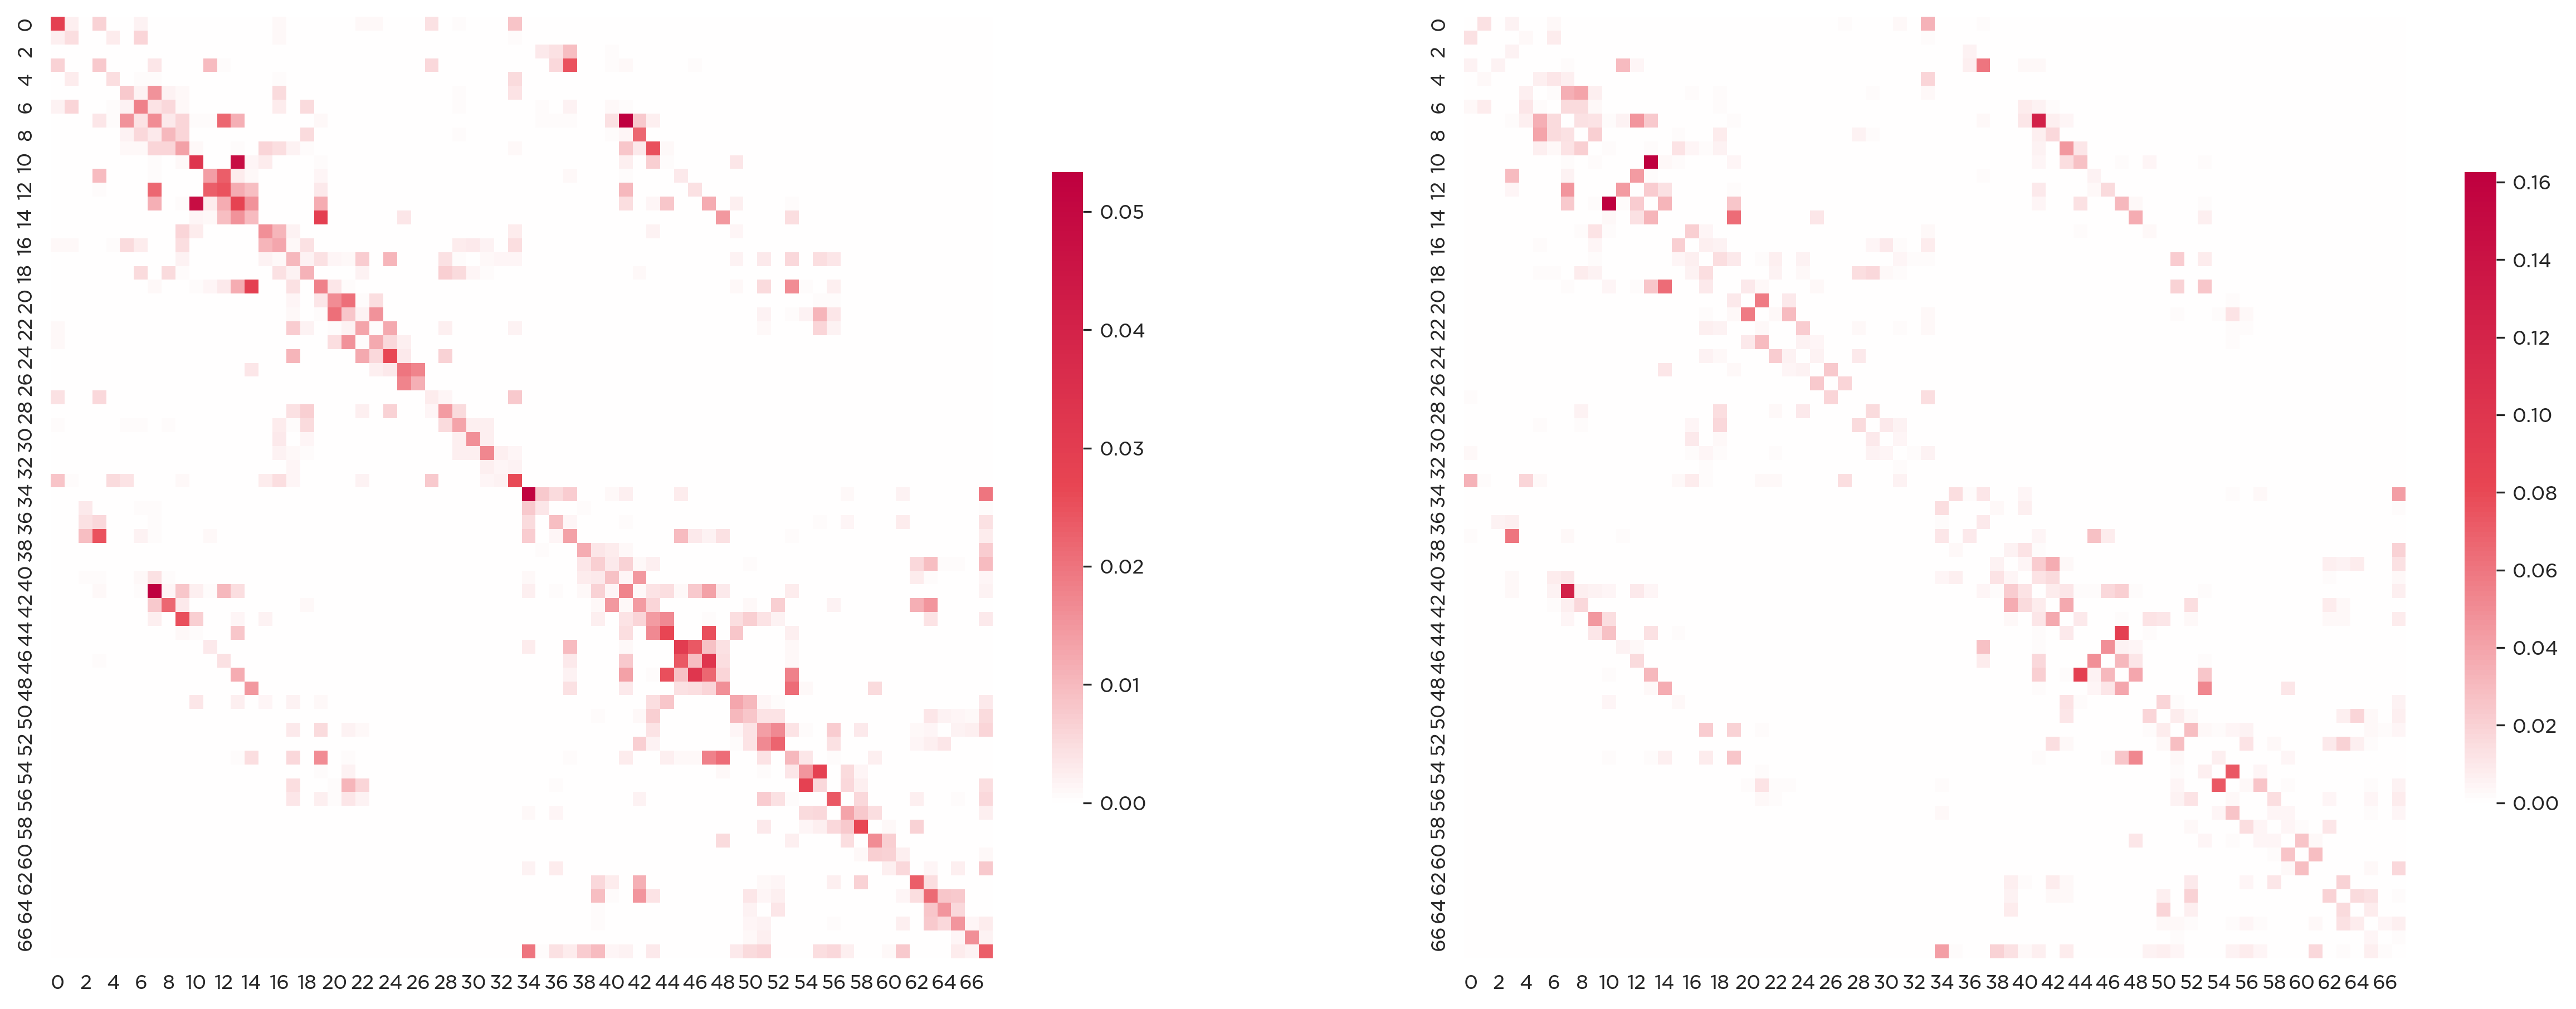

In [672]:
fig,axes = plt.subplot_mosaic(
    [['A','B']],figsize=(20,10),dpi=300)
sns.heatmap(mat['connMatrices']['SC'][0][:,:,1],square=True,center=0,
            cmap=colormap,cbar_kws={"shrink": .5},ax=axes['A'],linewidths=0., linecolor='k')
sns.heatmap(consmat['LauConsensus']['Matrices'][0][0],square=True,
            cmap=colormap,center=0,cbar_kws={"shrink": .5},ax=axes['B'],linewidths=0., linecolor='k')
## DIAGONALS ARE NOT ZERO

In [671]:
consmat['LauConsensus']['Matrices'][0][4][:,0]

array(['lateralorbitofrontal', 'parsorbitalis', 'frontalpole',
       'medialorbitofrontal', 'parstriangularis', 'parsopercularis',
       'rostralmiddlefrontal', 'superiorfrontal', 'caudalmiddlefrontal',
       'precentral', 'paracentral', 'rostralanteriorcingulate',
       'caudalanteriorcingulate', 'posteriorcingulate',
       'isthmuscingulate', 'postcentral', 'supramarginal',
       'superiorparietal', 'inferiorparietal', 'precuneus', 'cuneus',
       'pericalcarine', 'lateraloccipital', 'lingual', 'fusiform',
       'parahippocampal', 'entorhinal', 'temporalpole',
       'inferiortemporal', 'middletemporal', 'bankssts',
       'superiortemporal', 'transversetemporal', 'insula',
       'lateralorbitofrontal', 'parsorbitalis', 'frontalpole',
       'medialorbitofrontal', 'parstriangularis', 'parsopercularis',
       'rostralmiddlefrontal', 'superiorfrontal', 'caudalmiddlefrontal',
       'precentral', 'paracentral', 'rostralanteriorcingulate',
       'caudalanteriorcingulate', 'pos

In [605]:
for i in range(70):
    print(find_density(mat['connMatrices']['SC'][0][0][0][0][:,:,i]))

0.25670415224913495
0.30168685121107264
0.2670847750865052
0.3088235294117647
0.28784602076124566
0.2982266435986159
0.24870242214532873
0.2768166089965398
0.2897923875432526
0.26081314878892736
0.2936851211072664
0.28460207612456745
0.2861159169550173
0.2982266435986159
0.2649221453287197
0.2975778546712803
0.27465397923875434
0.3092560553633218
0.2897923875432526
0.24935121107266436
0.26686851211072665
0.2562716262975779
0.2869809688581315
0.2640570934256055
0.22253460207612458
0.27789792387543255
0.26124567474048443
0.28481833910034604
0.3088235294117647
0.2597318339100346
0.2564878892733564
0.2995242214532872
0.31682525951557095
0.28070934256055363
0.2763840830449827
0.2828719723183391
0.29411764705882354
0.26038062283737023
0.2768166089965398
0.28222318339100344
0.26600346020761245
0.28157439446366783
0.257136678200692
0.2634083044982699
0.24978373702422146
0.2545415224913495
0.2820069204152249
0.27984429065743943
0.28460207612456745
0.2876297577854671
0.26232698961937717
0.272491

/tmp/ipykernel_23554/977736901.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(normer(np.nan_to_num(np.log(eh[0][0][:,:,1]))))


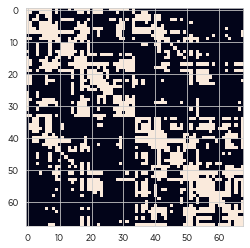

In [345]:
plt.imshow(normer(np.nan_to_num(np.log(eh[0][0][:,:,1]))))

''

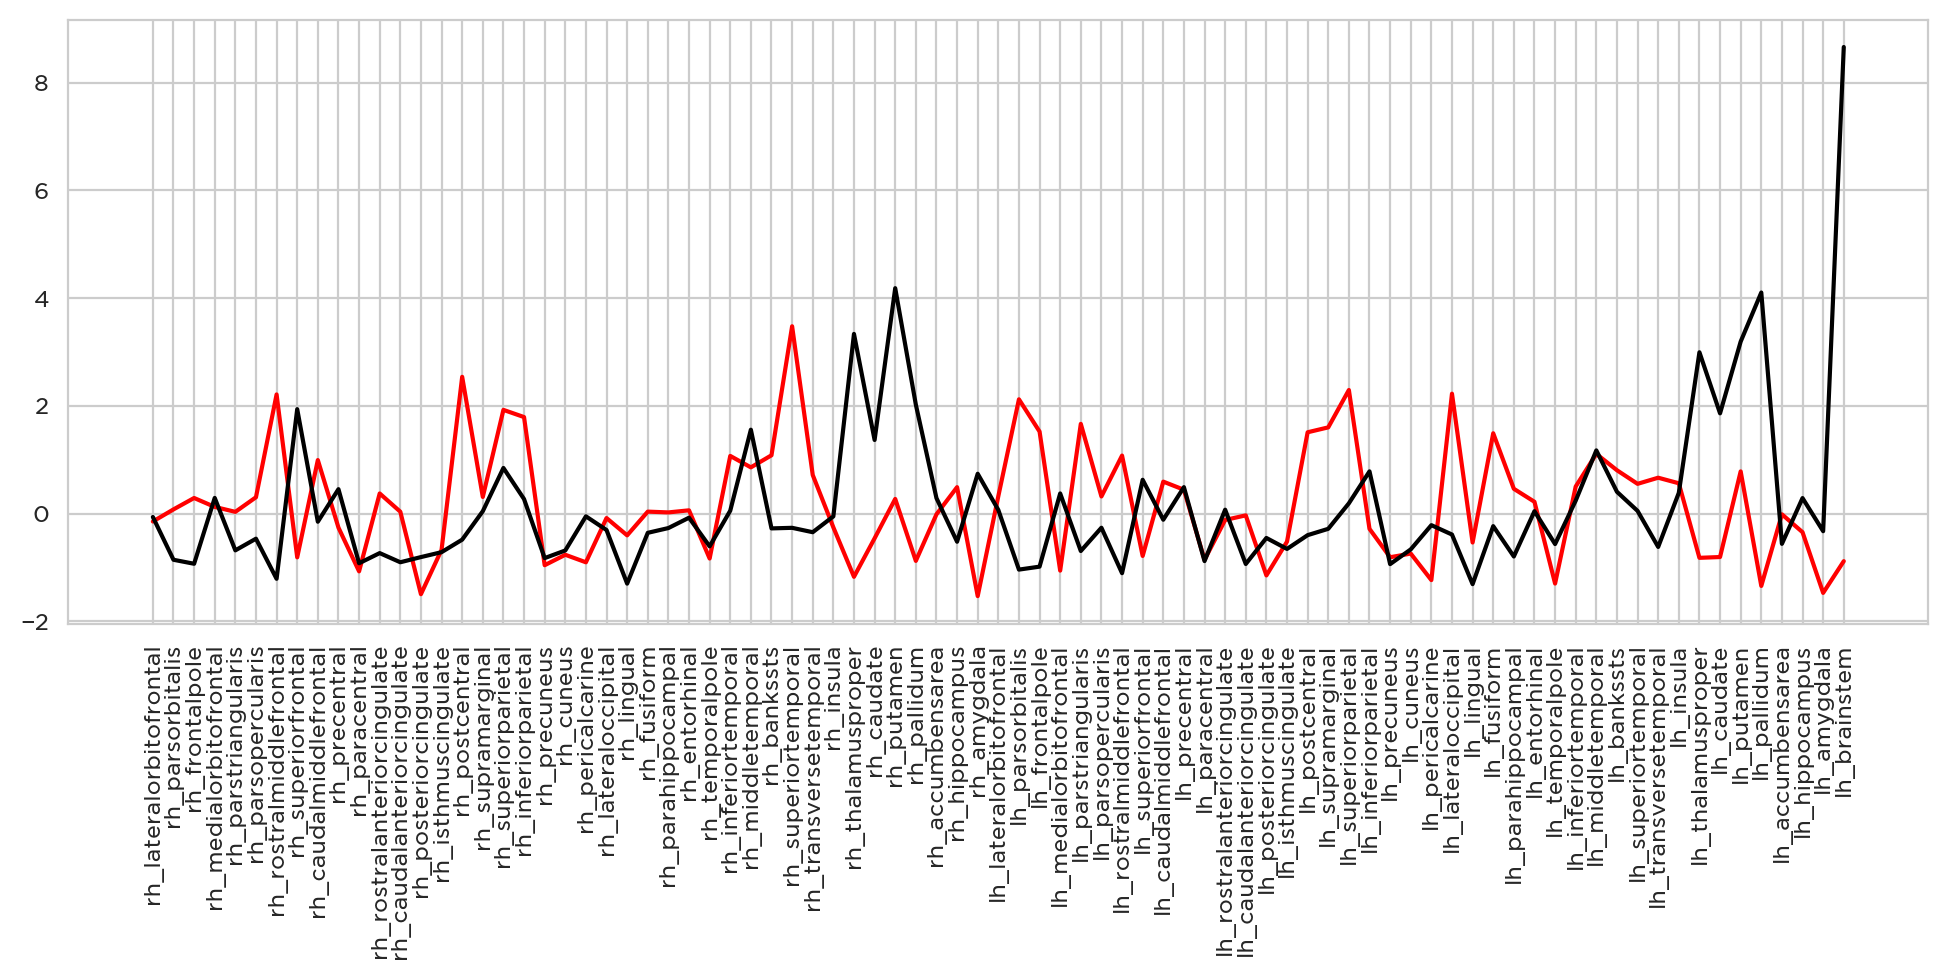

In [234]:
plt.figure(figsize=(12,4),dpi=200)
outgoing = np.sum(normer(cmodes)-normer(communicability_wei(connectivity)),axis=0)
incoming = np.sum(normer(cmodes)-normer(communicability_wei(connectivity)),axis=1)
plt.plot(outgoing,color='r')
plt.plot(incoming,color='k')
plt.xticks(rotation=90);

In [240]:
differencemat= normer(cmodes)-normer(communicability_wei(connectivity))

<AxesSubplot:>

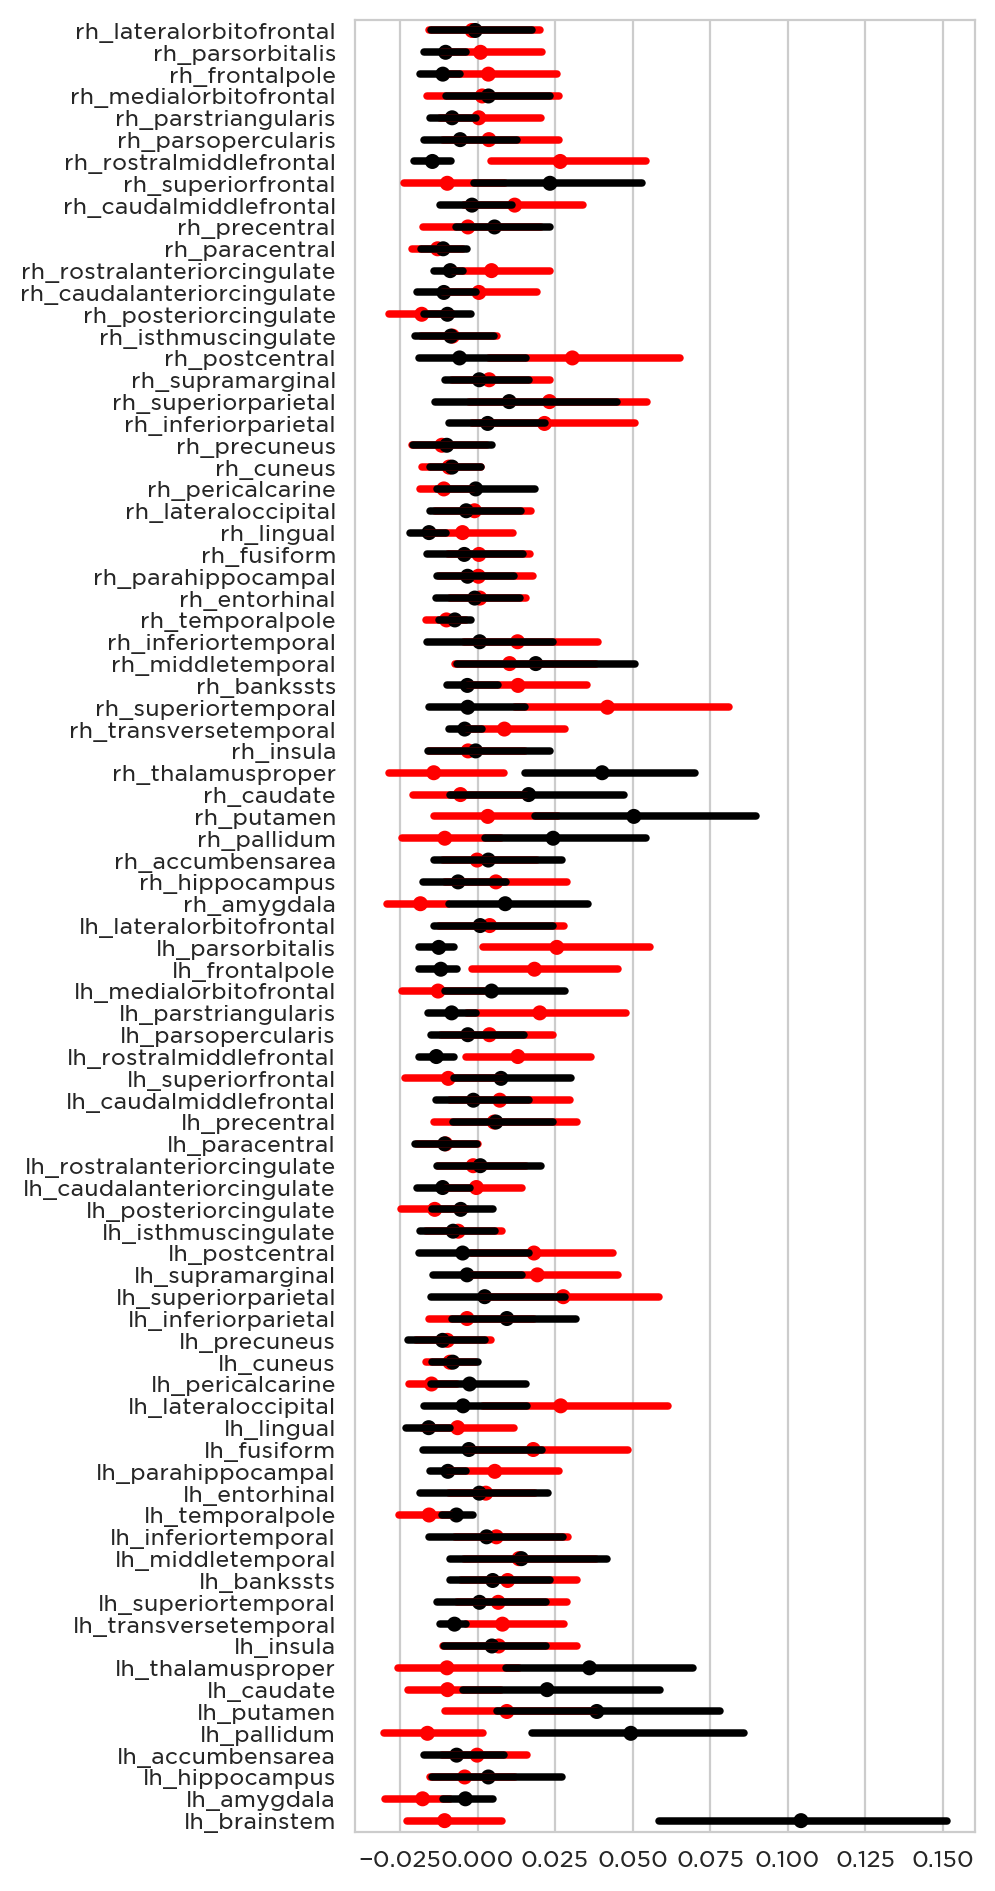

In [248]:
plt.figure(figsize=(4,12),dpi=200)
sns.pointplot(data=differencemat,color='r',join=False,markers='.',orient="h")
sns.pointplot(data=differencemat.T,color='k',join=False,markers='.',orient="h")

#plt.xticks(rotation=90);

/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

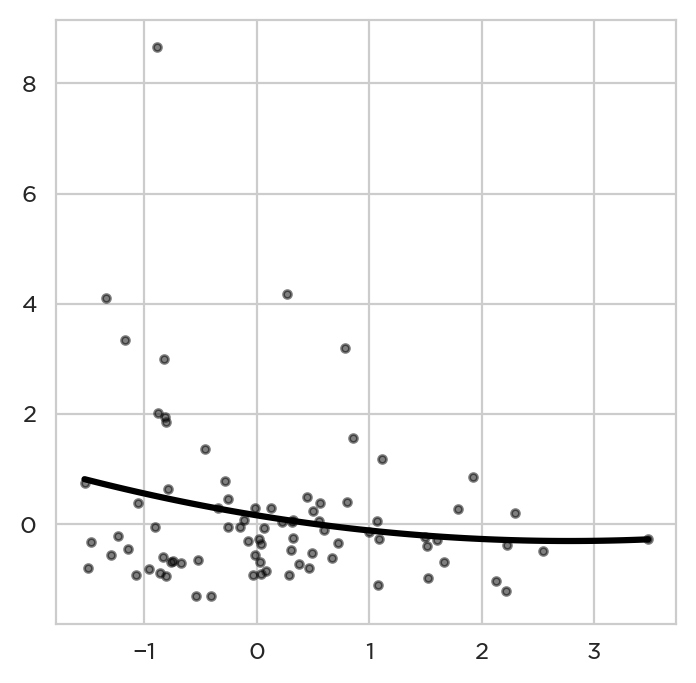

In [277]:
plt.figure(figsize=(4,4),dpi=200)
sns.regplot(outgoing,incoming,color='k',scatter_kws={'s':8,'alpha':0.5},fit_reg=True,order=2,ci=False)

In [254]:
variances = simple_stuff.var(axis=1)
mode_variances = cmodes.sum(axis=1)
external_variances = variances - mode_variances

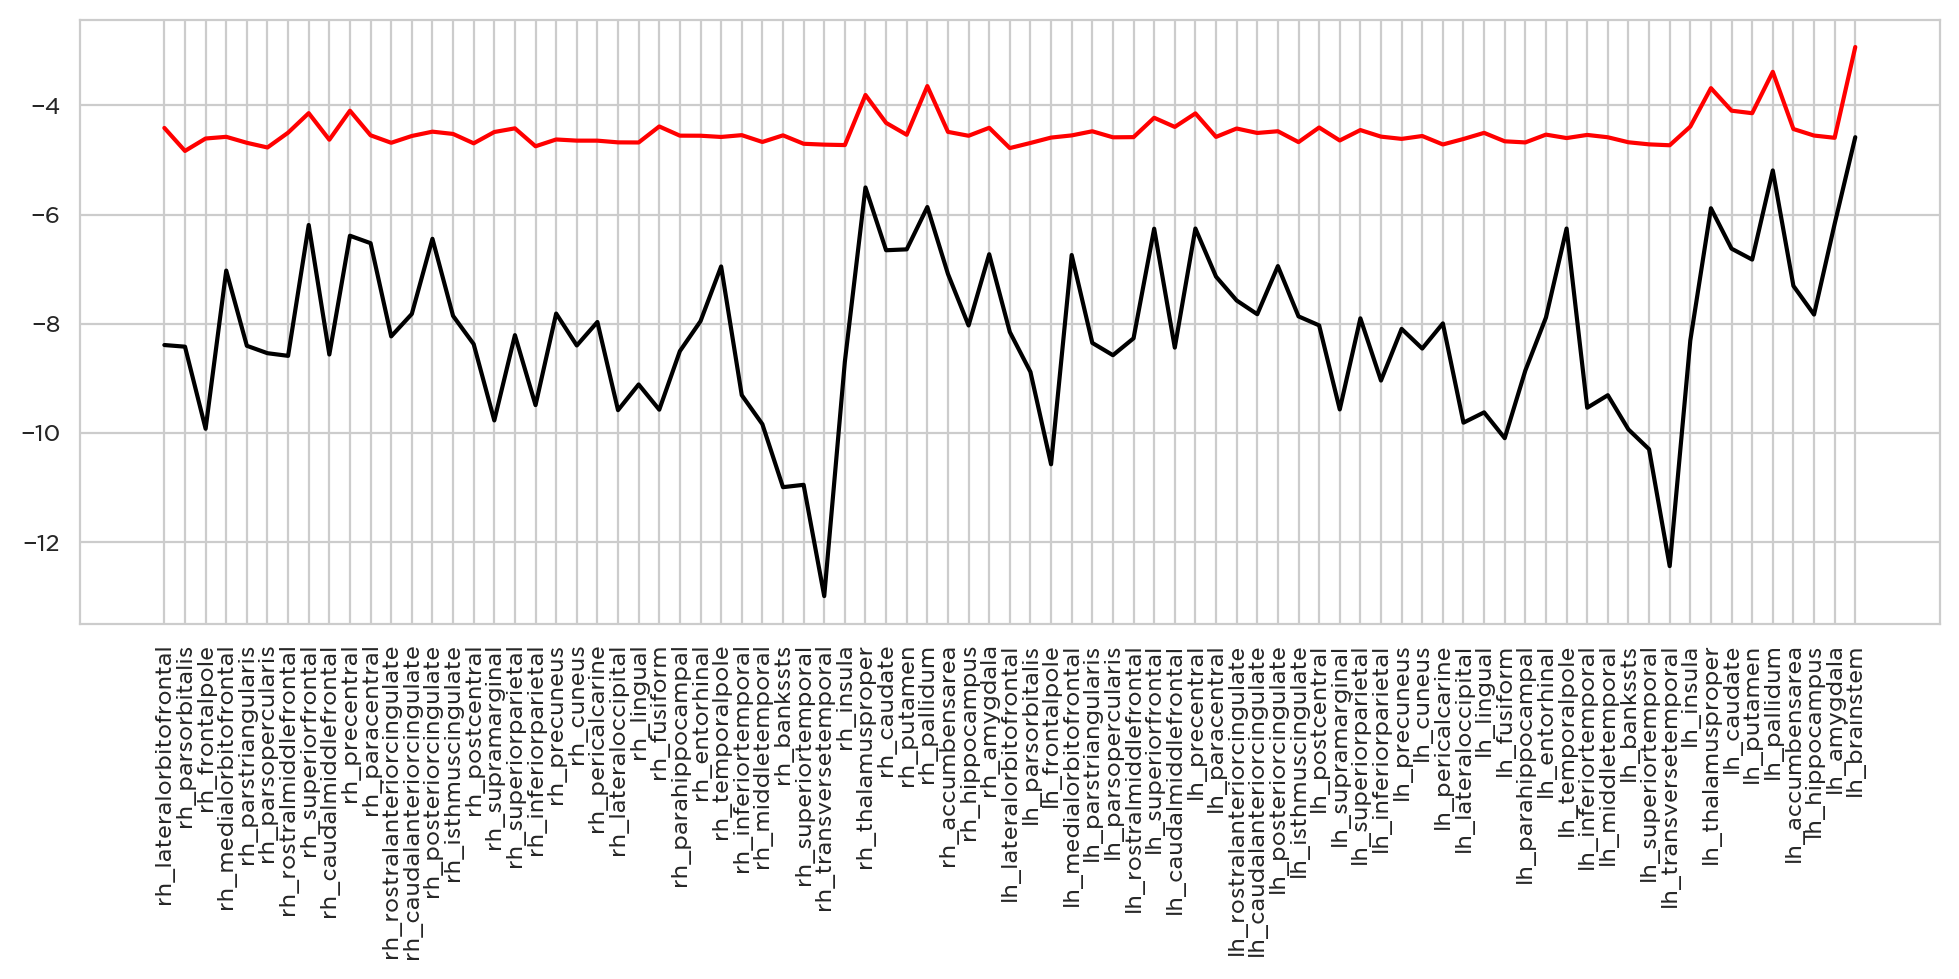

In [272]:
plt.figure(figsize=(12,4),dpi=200)
plt.plot(external_variances.apply(np.log),color='r')
plt.plot(mode_variances.apply(np.log),color='k')
plt.xticks(rotation=90);

/home/kayson/anaconda3/envs/pythonProject/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

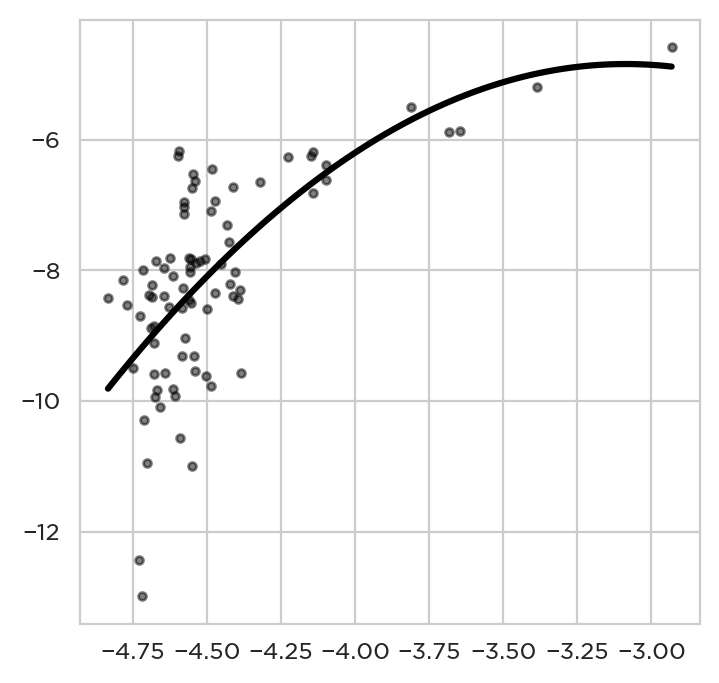

In [278]:
plt.figure(figsize=(4,4),dpi=200)
sns.regplot(external_variances.apply(np.log),mode_variances.apply(np.log),color='k',scatter_kws={'s':8,'alpha':0.5},fit_reg=True,order=2,ci=False)

<AxesSubplot:>

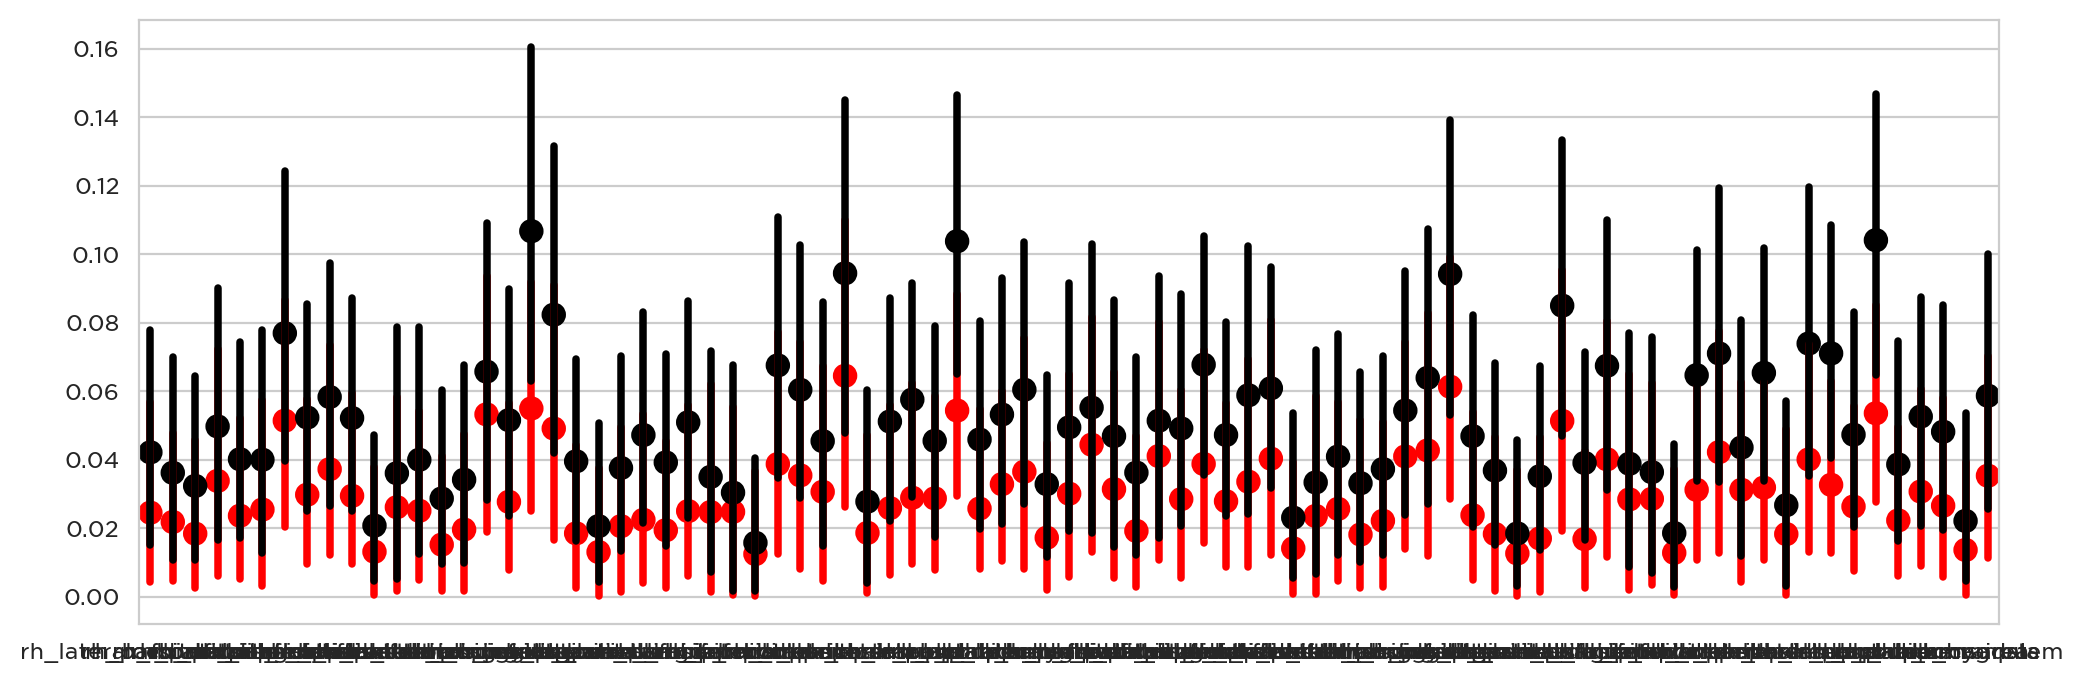

In [216]:
plt.figure(figsize=(12,4),dpi=200)

sns.pointplot(data = cmodes.apply(normer),color='r',join=False)
sns.pointplot(data = connectivitypd.apply(normer),color='k',join=False)

<AxesSubplot:>

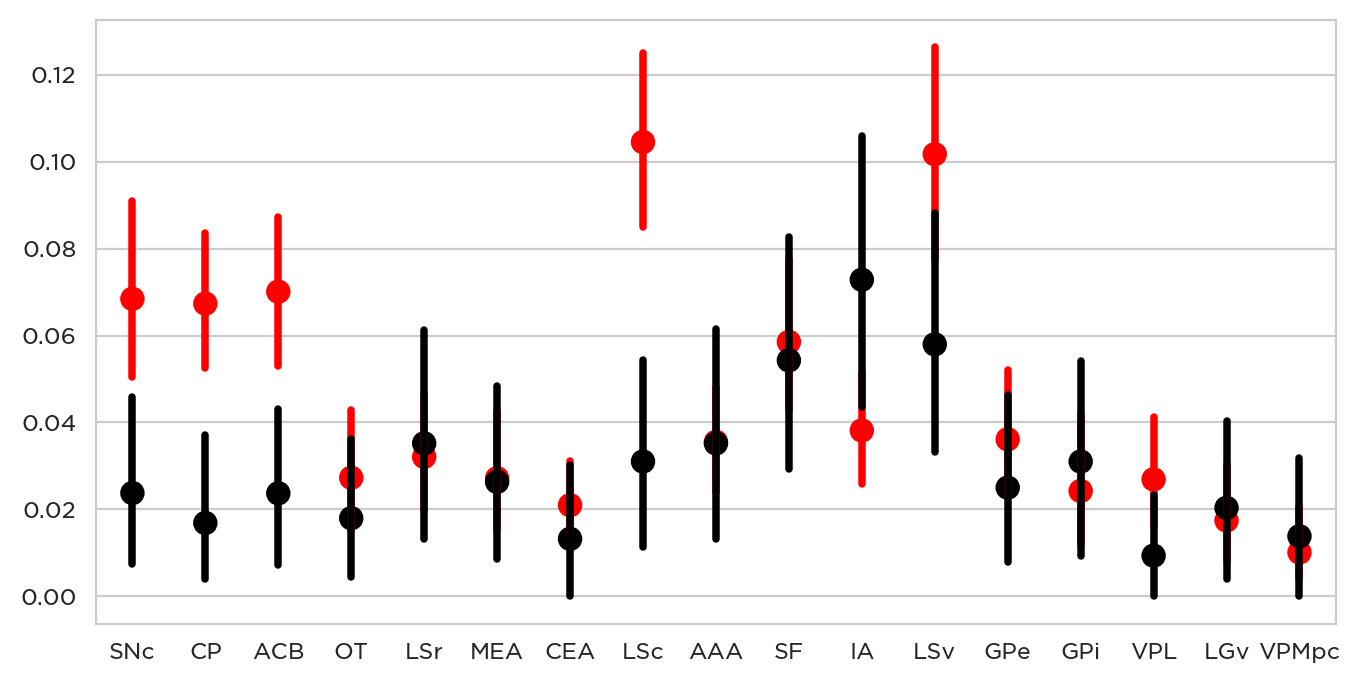

In [283]:
plt.figure(figsize=(8,4),dpi=200)
rois= ['SNc','CP','ACB','OT','LSr','MEA','CEA',
       'LSc','AAA','SF','IA','LSv','GPe','GPi','VPL','LGv','VPMpc']
sns.pointplot(data = cmodes[:][rois].apply(normer),color='r',join=False)
sns.pointplot(data = connectivitypd[:][rois].apply(normer),color='k',join=False)


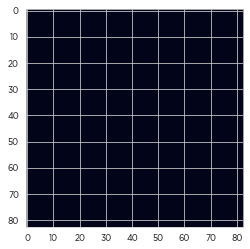

In [190]:
plt.imshow(communication_mask)

In [20]:
ci_mat

0         1         2         3         4         5   \
   timestamp                                                               
0  0               NaN  0.000000  0.000000  0.000000  0.000000  0.000000   
   1               NaN  0.000000  0.000000  0.000000  0.000000  0.000000   
   2               NaN -0.004005  0.000783  0.001036 -0.000046  0.000000   
   3               NaN  0.001443  0.000034  0.000959 -0.000190 -0.000453   
   4               NaN  0.000779  0.000309 -0.000814 -0.000035 -0.000368   
...                ...       ...       ...       ...       ...       ...   
82 195        0.000432 -0.000425 -0.000430  0.000600  0.004307  0.000620   
   196        0.000213 -0.000173 -0.000568  0.000500  0.003036  0.000127   
   197        0.000382 -0.000673 -0.000419  0.000237  0.002814 -0.000369   
   198        0.000157  0.000680 -0.000163 -0.000326  0.001861 -0.000454   
   199       -0.000527  0.000297 -0.000441 -0.000121  0.001464 -0.000177   

                    6         7         8         9   ...            73  \
   timestamp                                          ...                 
0  0          0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
   1          0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
   2         -0.000779 -0.000003  0.000000  0.000000  ...  0.000000e+00   
   3          0.000582 -0.000065 -0.000029  0.000299  ...  0.000000e+00   
   4         -0.001546  0.000301 -0.000075  0.000002  ... -1.967960e-08   
...                ...       ...       ...       ...  ...           ...   
82 195        0.001116 -0.001373  0.001249 -0.001567  ... -1.528138e-06   
   196        0.001066  0.016357  0.000891  0.033260  ... -8.949938e-07   
   197        0.002081  0.023424 -0.000174  0.012939  ... -1.066915e-05   
   198        0.001341  0.026181 -0.000288  0.027907  ...  5.749823e-06   
   199        0.000547  0.023685 -0.000178  0.019931  ... -2.554893e-07   

                    74        75        76        77        78        79  \
   timestamp                                                               
0  0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   1          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   2          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   3         -0.000006 -0.000004 -0.000011  0.000005  0.000008 -0.000158   
   4         -0.000002 -0.000055  0.000072  0.000005  0.000075 -0.000351   
...                ...       ...       ...       ...       ...       ...   
82 195        0.000888  0.045296 -0.002013  0.011899  0.058198  0.003285   
   196        0.000739  0.038986 -0.001541  0.009338 -0.021254  0.003728   
   197        0.000364  0.041490  0.001484  0.007771  0.031940  0.003284   
   198        0.000300  0.021202 -0.005764  0.014096  0.060114  0.003191   
   199        0.000857  0.006950  0.000073  0.008293  0.051575  0.003047   

                    80            81        82  
   timestamp                                    
0  0          0.000000  0.000000e+00  0.000000  
   1          0.000000  0.000000e+00  0.000000  
   2          0.000000  0.000000e+00  0.000000  
   3         -0.000002 -4.677791e-07  0.000235  
   4         -0.000004  1.616374e-06  0.000625  
...                ...           ...       ...  
82 195        0.000804  2.213486e-03       NaN  
   196        0.000541  1.331588e-03       NaN  
   197       -0.000711 -1.254094e-05       NaN  
   198       -0.000575 -7.088864e-04       NaN  
   199       -0.001781 -6.628438e-05       NaN  

[16600 rows x 83 columns]

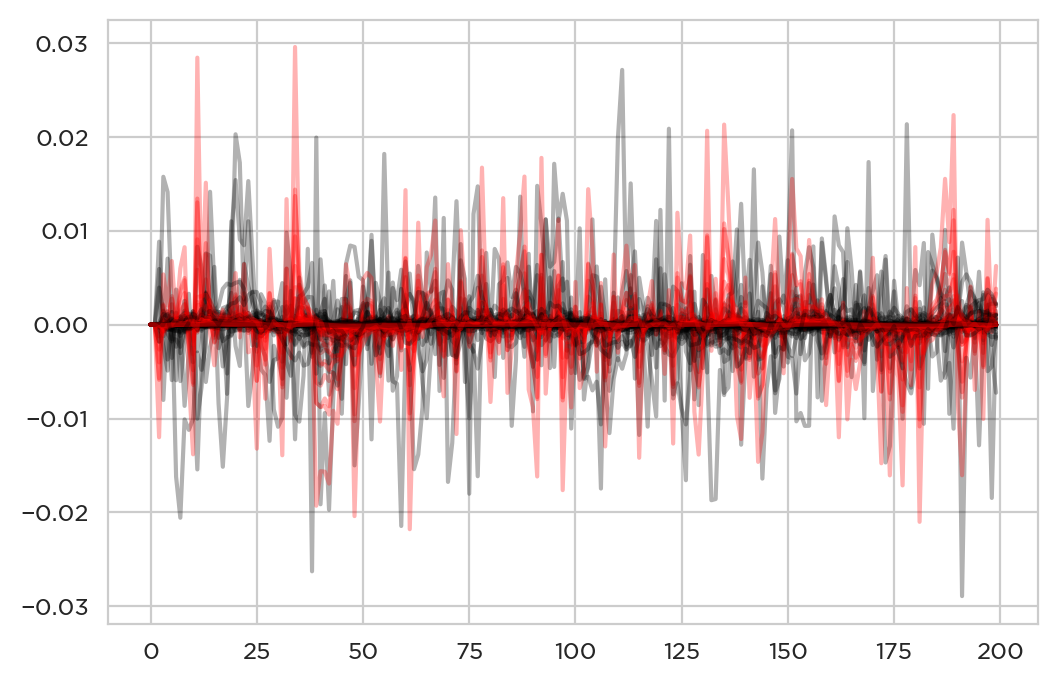

In [19]:
plt.figure(dpi=200)
for i in range(n_neurons):
    plt.plot(ci_mat[i][1],'k',alpha=0.3) # influence on the node
    plt.plot(ci_mat[1][i],'r',alpha=0.3) # influenced by the node
#plt.plot(input[5])

In [184]:
comm = np.exp(connectivity!=0)

In [461]:
human_comunicability = communicability_wei(connectivity)

/tmp/ipykernel_23554/1566783491.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.4)


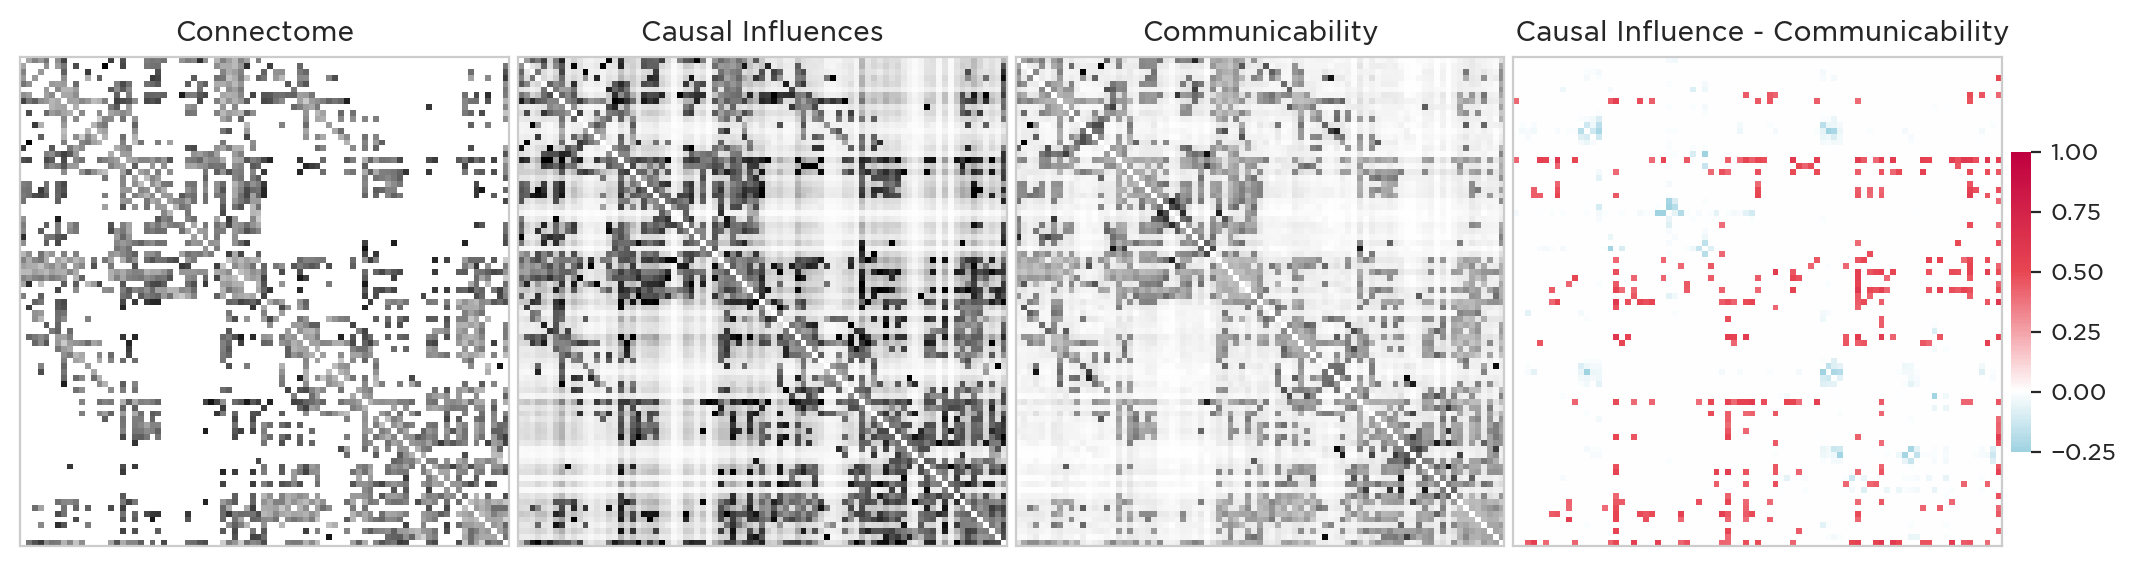

In [462]:
normalized_ci = normer(cmodes)
normalized_comm = normer(human_comunicability)
diff = normalized_ci - normalized_comm
diff = diff.fillna(0)
# thr = diff.max()/2


lower = np.percentile(diff, 5)
upper = np.percentile(diff, 95)
diff[(diff < upper) & (diff > lower)] = 0
fig, axes = plt.subplot_mosaic(
    [['X', 'A', 'B', 'C']], figsize=(10, 5), dpi=200)

cbar_ax = fig.add_axes([1, .35, .01, .3])

sns.heatmap(connectivity, square=True,
            cmap='binary', cbar_kws={"shrink": .5},
            ax=axes['X'], linewidths=0., linecolor='k',
            xticklabels=False,yticklabels=False, cbar = False)
sns.heatmap(diff, square=True,
            cmap=colormap, center=0, cbar_kws={"shrink": .5}, ax=axes['C'], linewidths=0.,vmax=1,vmin=-0.25, linecolor='k',xticklabels=False,yticklabels=False, cbar_ax = cbar_ax)
sns.heatmap(normalized_comm, square=True,
            cmap='binary', cbar_kws={"shrink": .5}, ax=axes['B'], linewidths=0., linecolor='k',xticklabels=False,yticklabels=False,cbar=False)
sns.heatmap(normalized_ci, square=True,
            cmap='binary', cbar_kws={"shrink": .5}, ax=axes['A'], linewidths=0., linecolor='k',xticklabels=False,yticklabels=False,cbar=False)
axes['C'].title.set_text(' Causal Influence - Communicability')
axes['B'].title.set_text('Communicability')
axes['A'].title.set_text('Causal Influences')
axes['X'].title.set_text('Connectome')

for ax in axes:
    axes[ax].spines['right'].set_visible(True)
    axes[ax].spines['top'].set_visible(True)
    axes[ax].spines['bottom'].set_visible(True)
    axes[ax].spines['left'].set_visible(True)

fig.tight_layout(pad=0.4)
#fig.legend(bbox_to_anchor=(0.97, 0.5),frameon=False,handletextpad=0.01)

#plt.savefig(f"CO vs CI.pdf",dpi=600,bbox_inches='tight')

In [292]:
commpy = pd.DataFrame(comm,columns=mouse.columns,index=mouse.columns)

<AxesSubplot:>

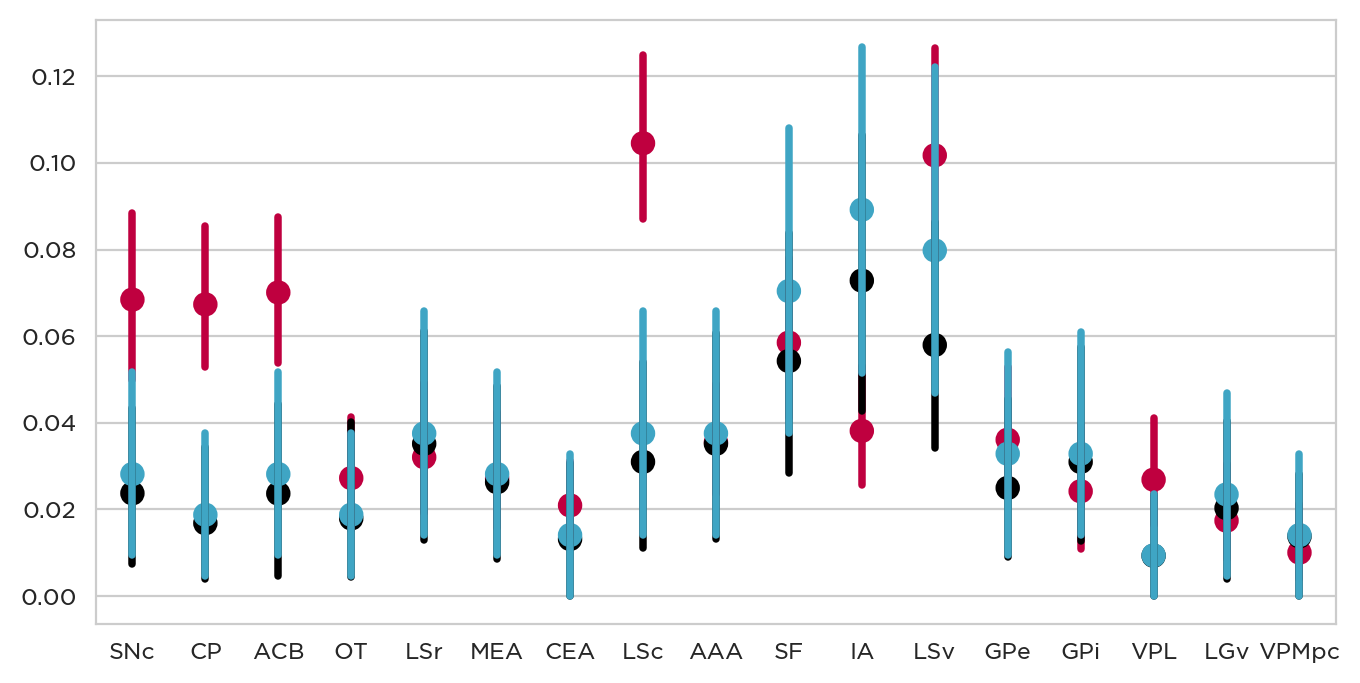

In [297]:
plt.figure(figsize=(8,4),dpi=200)

sns.pointplot(data = cmodes[:][rois].apply(normer),color='#BF003F',
              join=False,label = 'causal influence')
sns.pointplot(data = connectivitypd[:][rois].apply(normer),
              color='k',join=False,label = 'weights')
sns.pointplot(data = commpy[:][rois].apply(normer),color='#3FA5C4',join=False,label = 'communicability')


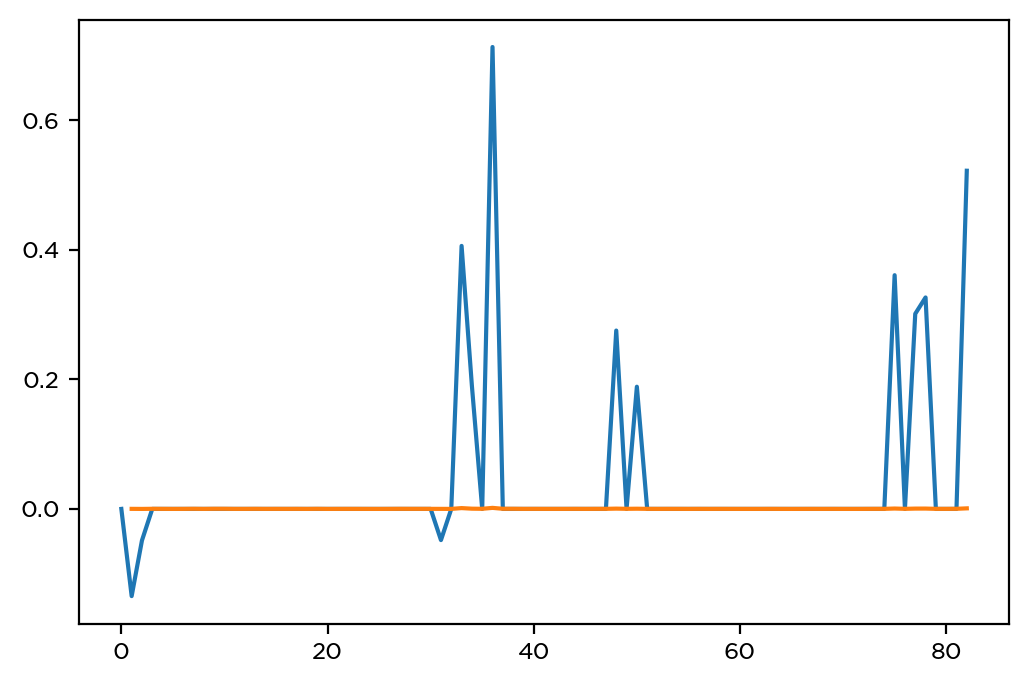

In [854]:
plt.figure(dpi=200)
plt.plot(diff[0])
plt.plot(cmodes[0])

In [427]:
diff[0][:]

0     0.000000
1     0.000000
2    -0.041492
3     0.000000
4     0.000000
        ...   
78    0.000000
79    0.000000
80    0.000000
81    0.000000
82    0.000000
Name: 0, Length: 83, dtype: float64

In [340]:
cmodes[0][1]

0.006210604105173118

In [ ]:
# drosophila = 78.24
# human = 70.50
# reproducing human = 66.85
# rat = 0.07
# Macaque = 131.48
# Row Shuffled human = 862.39
# Row and Column shuffled human = 903.066

In [293]:
70.50/83

0.8493975903614458

In [294]:
78.24/49

1.5967346938775508

In [ ]:
def control_simple_nodes(complements, network, index, input):
    # if len(complements) == len(network) - 1:
    #     return np.zeros(input.shape[1] - 10).squeeze()
        #return 0.0
    lesioned_network = deepcopy(network)
    for target in complements:
        lesioned_network[:, target] = 0.0
    dynamics = simple_dynamical_system(lesioned_network, input)

    lesioned_signal = dynamics[index, 10:]
    rng.shuffle(lesioned_signal)
    #return np.sum(intact_signal - lesioned_signal)
    #return mean_squared_error(intact_signal,lesioned_signal)
    return lesioned_signal
    #return float(np.linalg.norm(lesioned_signal))


lesion_params = {'network': connectivity, 'input': input}
ci_mat_control = msa.estimate_causal_influences(elements=list(range(n_neurons)),
                                        objective_function=control_simple_nodes,
                                        objective_function_params=lesion_params,
                                        n_permutations=1_000, n_cores=-1)

In [251]:
from scipy.stats import entropy

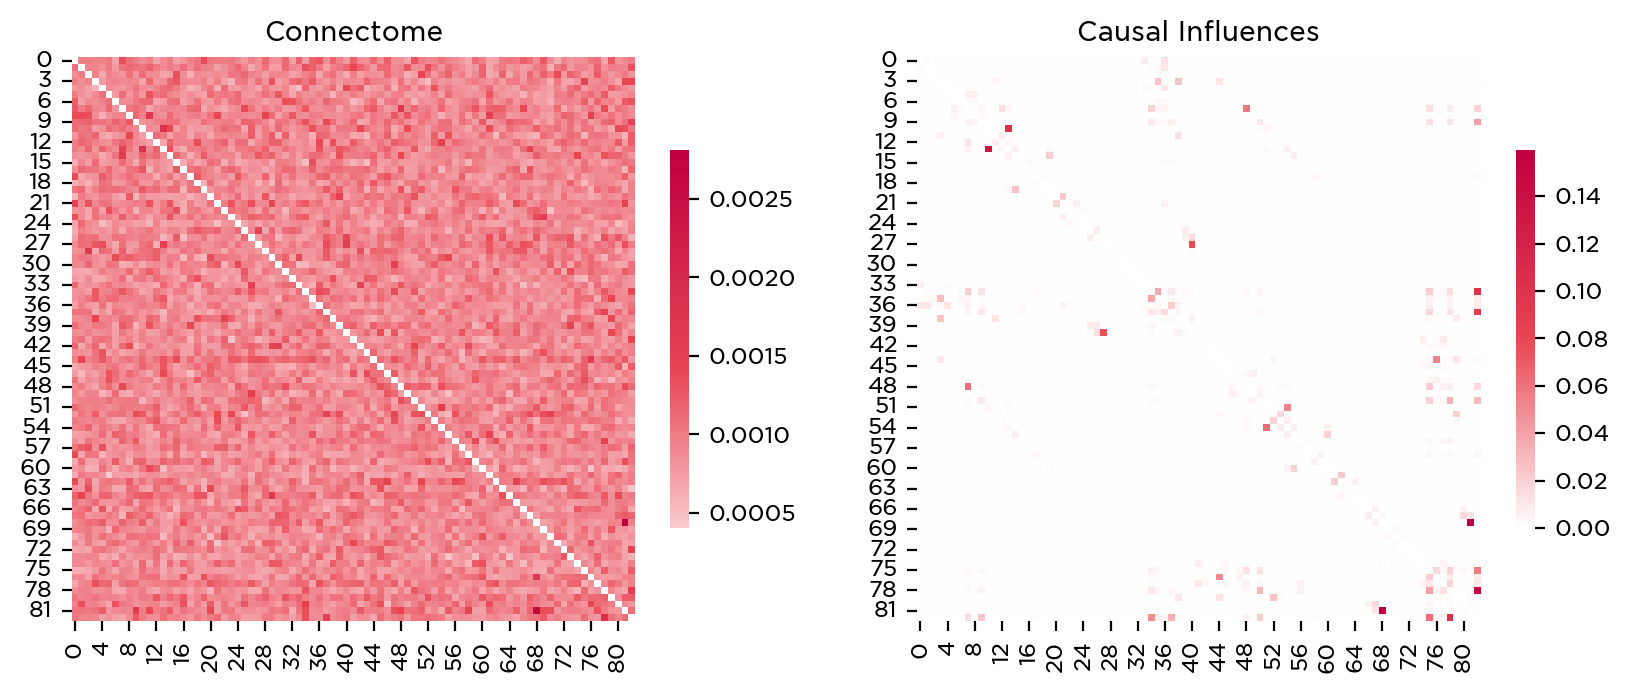

In [714]:
controlmodes = ci_mat_control.groupby(level=0).var()


fig, axes = plt.subplot_mosaic(
    [['A', 'B']], figsize=(10, 5), dpi=200)
sns.heatmap(controlmodes, square=True, center=0,
            cmap=colormap, cbar_kws={"shrink": .5}, ax=axes['A'], linewidths=0., linecolor='k')
sns.heatmap(cmodes * communication_mask, square=True,
            cmap=colormap, center=0, cbar_kws={"shrink": .5}, ax=axes['B'], linewidths=0., linecolor='k')
axes['A'].title.set_text('Connectome')
axes['B'].title.set_text('Causal Influences')


In [142]:
controlmodes

0    1    2    3    4    5    6    7    8    9   ...   73   74   75   76  \
0   NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
78  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
79  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
80  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
81  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
82  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

     77   78   79   80   81   82  
0   0.0  0.0  0.0  0.0  0.0  0.0  
1   0.0  0.0  0.0  0.0  0.0  0.0  
2   0.0  0.0  0.0  0.0  0.0  0.0  
3   0.0  0.0  0.0  0.0  0.0  0.0  
4   0.0  0.0  0.0  0.0  0.0  0.0  
..  ...  ...  ...  ...  ...  ...  
78  0.0  NaN  0.0  0.0  0.0  0.0  
79  0.0  0.0  NaN  0.0  0.0  0.0  
80  0.0  0.0  0.0  NaN  0.0  0.0  
81  0.0  0.0  0.0  0.0  NaN  0.0  
82  0.0  0.0  0.0  0.0  0.0  NaN  

[83 rows x 83 columns]

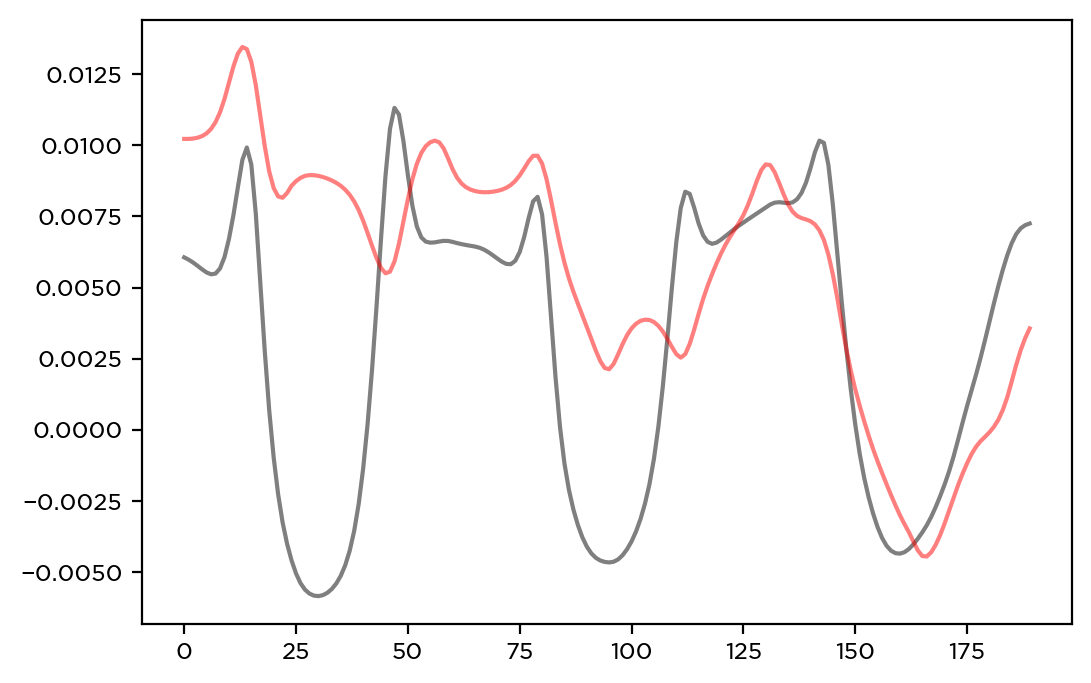

In [855]:
plt.figure(dpi=200)

plt.plot(ci_mat[0][20],'k',alpha=0.5) # influence of [a] on the node [b]
plt.plot(ci_mat[20][0],'r',alpha=0.5) # influenced by the node

# plt.plot(ci_mat_control[1][0],'b',alpha=0.3) # influence on the node
# plt.plot(ci_mat_control[0][1],'g',alpha=0.3) # influenced by the node

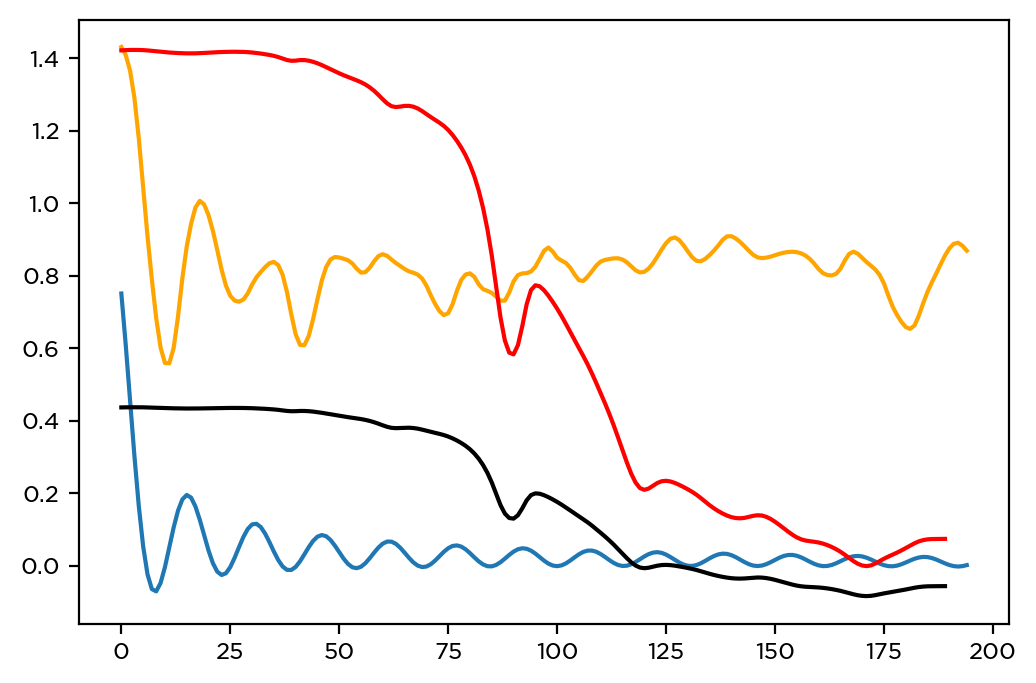

In [856]:
plt.figure(dpi=200)
#plt.plot(ci_mat_control.groupby(level=1).mean().mean(axis=1),'g',alpha=0.8)
#plt.plot(ci_mat.groupby(level=1).mean().mean(axis=1),'k',alpha=0.8)
plt.plot(input[:,5:].mean(axis=0))
plt.plot(simple_stuff[:,5:].mean(axis=0)+0.5,'orange')
plt.plot(ci_mat.loc[5].mean(axis=1)*30+0.1,'k')
plt.plot(ci_mat.loc[5].sum(axis=1)+0.5,'r')

In [857]:
arr = ci_mat.values.reshape(n_neurons, timesteps-10,n_neurons)
arr = np.nan_to_num(arr)

In [858]:
arr.shape

(83, 190, 83)

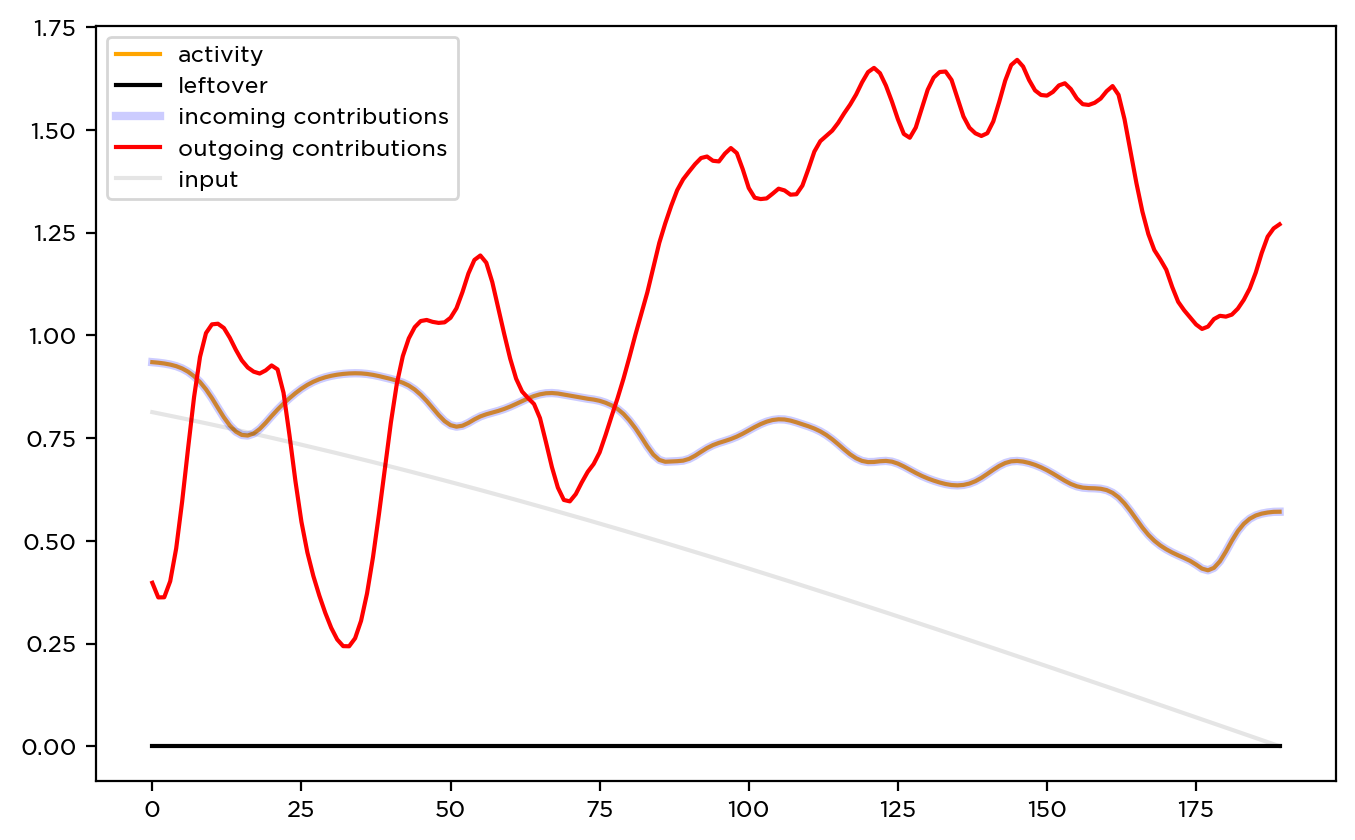

In [865]:
plt.figure(figsize=(8,5),dpi=200)
testnode=0
plt.plot(simple_stuff[testnode,10:],'orange',label='activity')
plt.plot(simple_stuff[testnode,10:]-(arr[testnode].sum(axis=1)),'k',label='leftover')

#plt.plot(arr[testnode].sum(axis=1)+input[testnode,10:],'purple',alpha=1,label='incoming contributions + input')
plt.plot(arr[testnode].sum(axis=1),'blue',label='incoming contributions',alpha=0.2,lw=3)

plt.plot(arr[:,:,testnode].sum(axis=0),'r',label='outgoing contributions')
plt.plot(input[testnode,10:],'k',label='input',alpha=0.1)
plt.legend()

In [552]:
simple_stuff[2,10:].shape

(190,)

In [627]:
cmodes.mean(axis=1) #incoming influences

0     0.000012
1     0.000010
2     0.000002
3     0.000038
4     0.000009
        ...   
78    0.000040
79    0.000035
80    0.000019
81    0.000238
82    0.000092
Length: 83, dtype: float64

In [628]:
cmodes.mean(axis=0) #outgoing influences

0     1.580385e-06
1     6.188257e-07
2     1.116935e-07
3     8.241232e-06
4     1.462409e-06
          ...     
78    7.666111e-05
79    2.296915e-05
80    1.341785e-05
81    1.898574e-04
82    2.515182e-04
Length: 83, dtype: float64

In [613]:
12/0.2

60.0

In [769]:
doers = cmodes.fillna(0).mean(axis=1)/cmodes.fillna(0).mean(axis=0)

In [770]:
entropy(cmodes.fillna(0)).shape

(83,)

<AxesSubplot:ylabel='Count'>

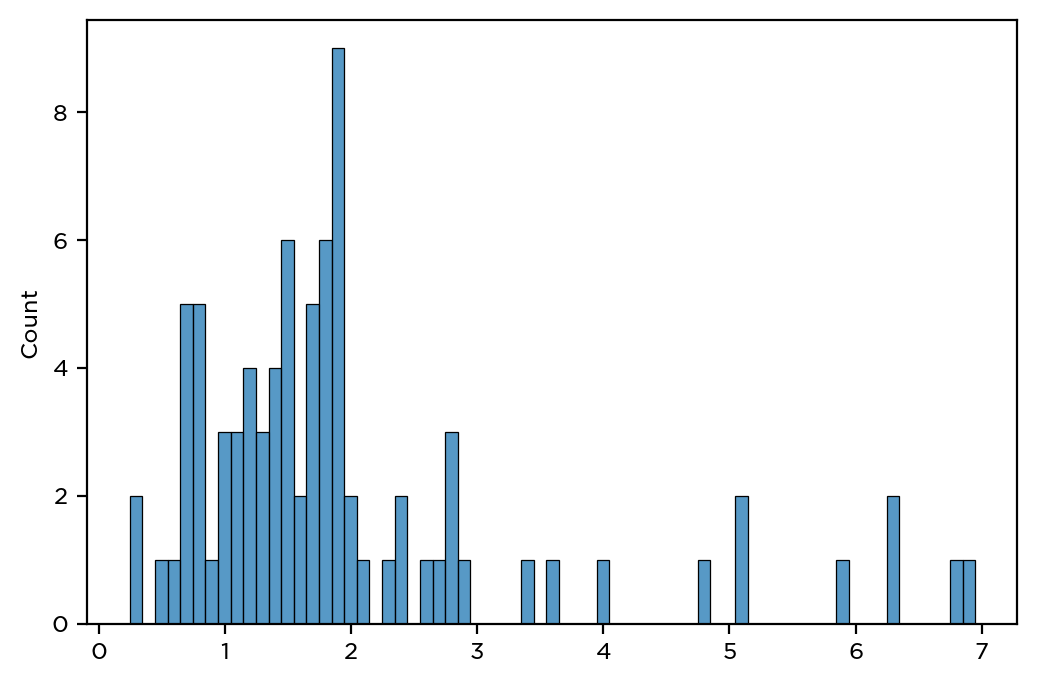

In [771]:
plt.figure(dpi=200)
sns.histplot(doers,binwidth=0.1)
#plt.plot(doers)

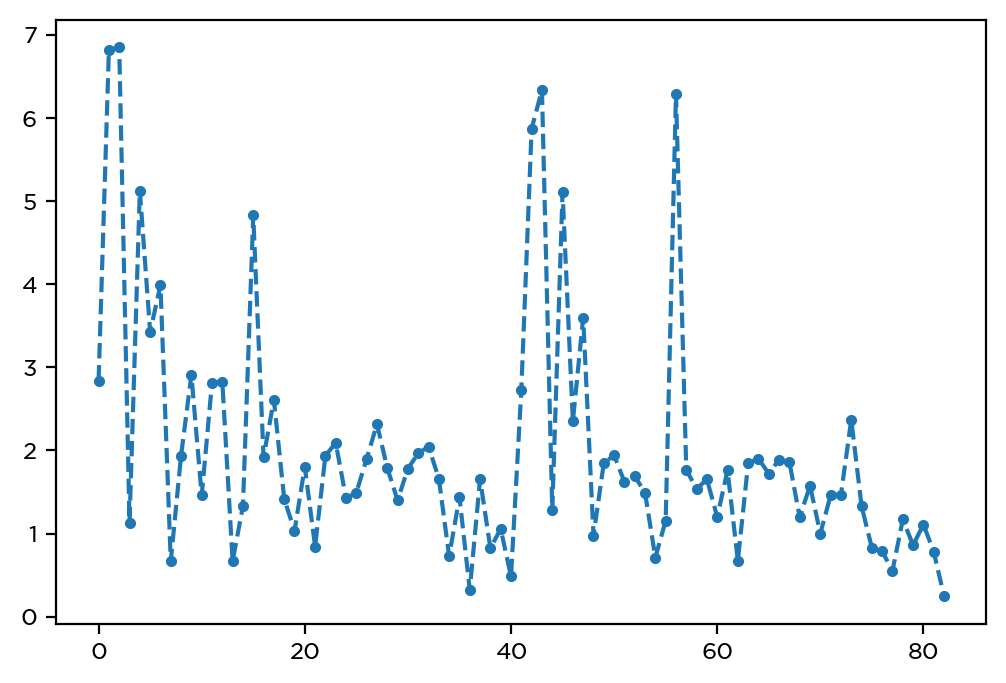

In [772]:
plt.figure(dpi=200)
plt.plot(doers,'--.')


In [563]:
doers.mean()

1.1190281231188575

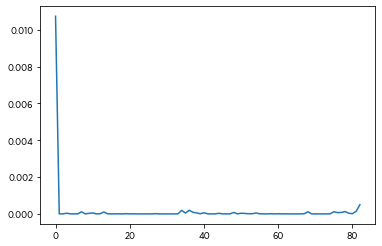

In [370]:
plt.plot(cmodes.fillna(0).mean(axis='index'))

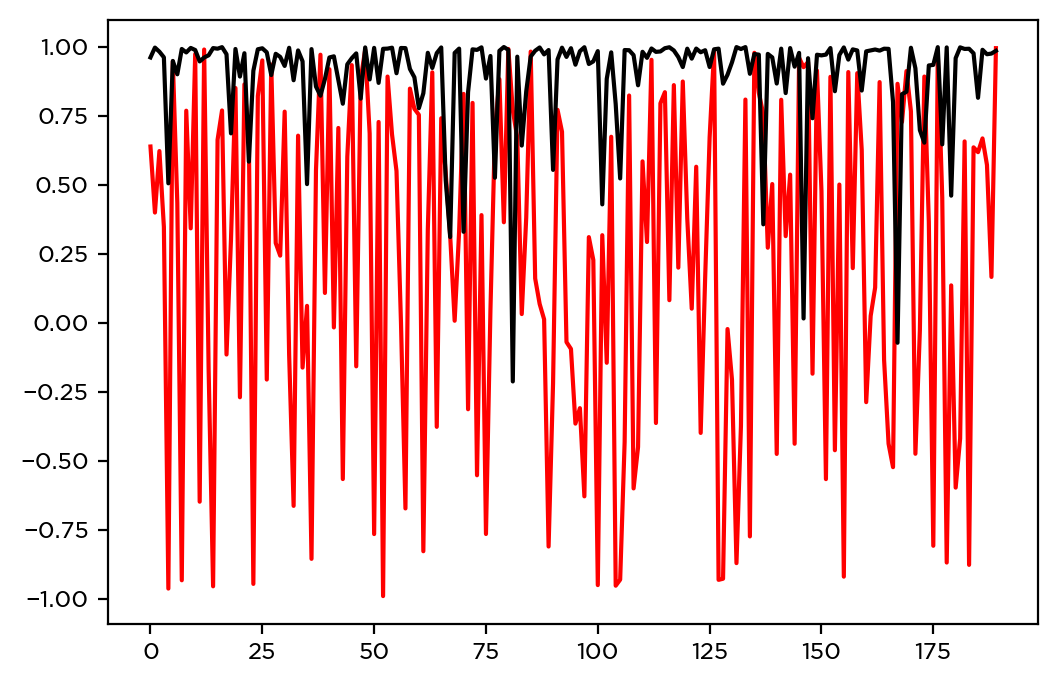

In [242]:
plt.figure(dpi=200)

plt.plot(simple_stuff[33,10:],'r')
plt.plot(simple_stuff[78,10:],'k')

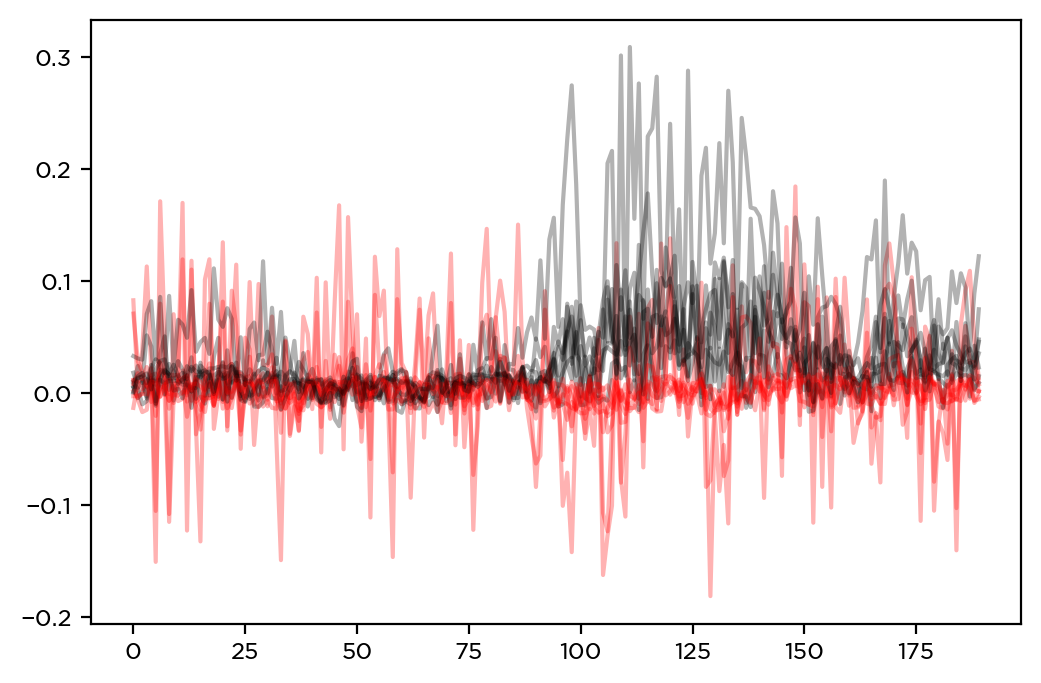

In [163]:
plt.figure(dpi=200)
for i in range(n_neurons-75):
    plt.plot(ci_mat[33][i],'r',alpha=0.3) # influenced by the node
    plt.plot(ci_mat[78][i],'k',alpha=0.3)

In [132]:
input[:,10:].mean(axis=0).shape

(190,)

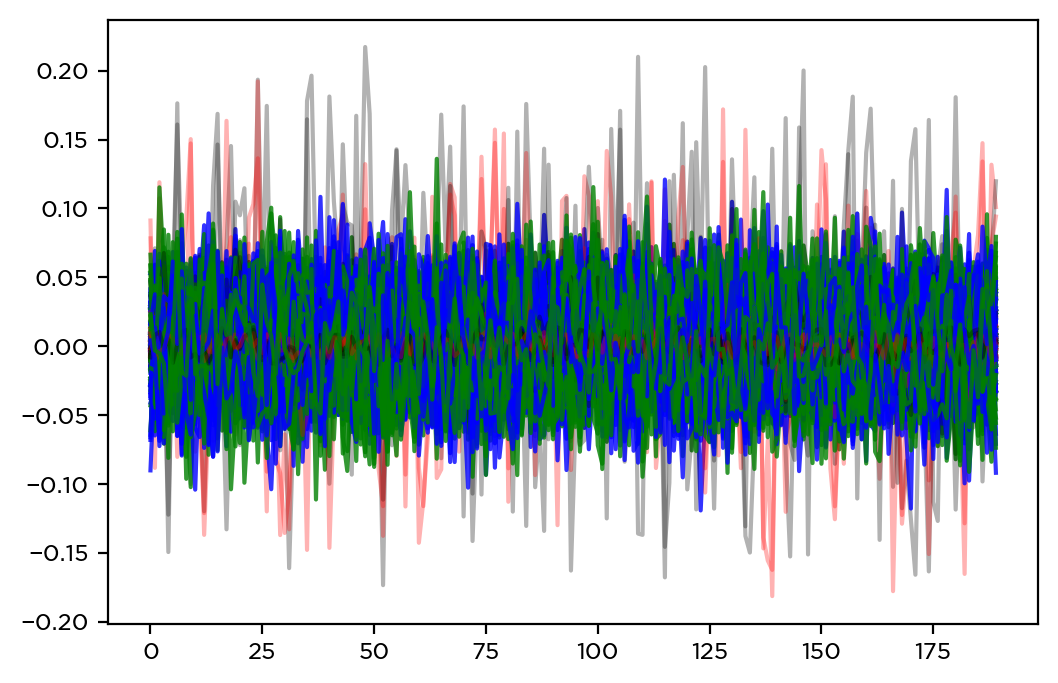

In [172]:
plt.figure(dpi=200)
for i in range(n_neurons-30):
    plt.plot(ci_mat[i][5],'k',alpha=0.3) # influence on the node
    plt.plot(ci_mat[5][i],'r',alpha=0.3) # influenced by the node
    plt.plot(ci_mat_control[i][5],'b',alpha=0.8) # influence on the node
    plt.plot(ci_mat_control[5][i],'g',alpha=0.8) # influenced by the node

<AxesSubplot:ylabel='Count'>

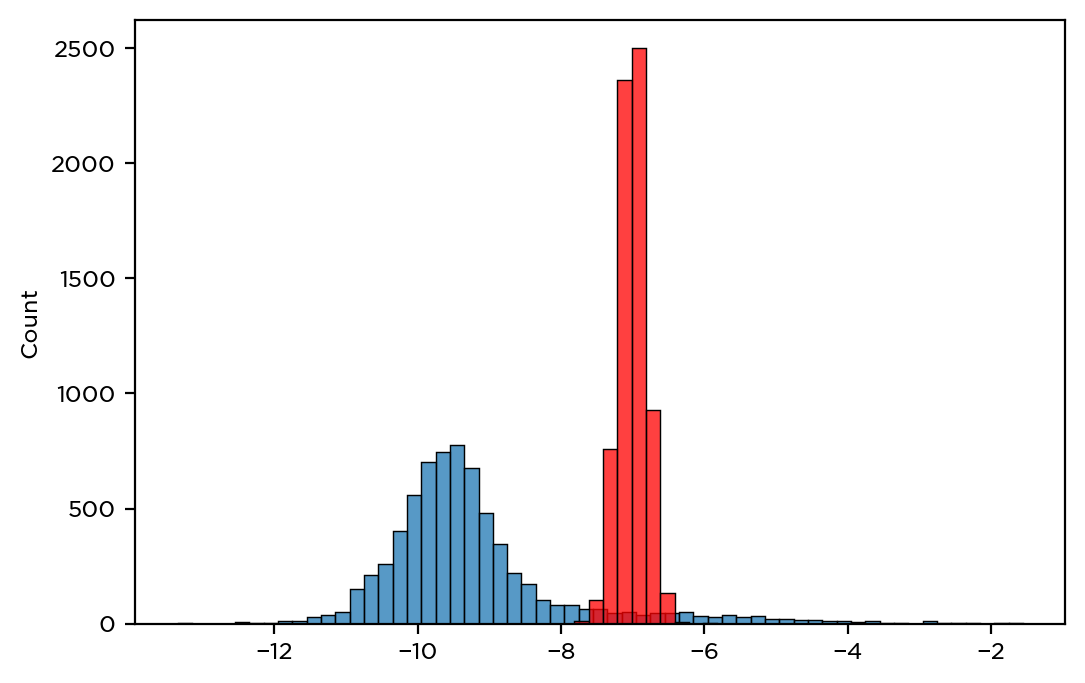

In [175]:
plt.figure(dpi=200)
sns.histplot(np.log(cmodes.stack().values),binwidth=0.2)
sns.histplot(np.log(controlmodes.stack().values),binwidth=0.2,color='r')

In [176]:
np.max(cmodes.stack().values)

0.19780018348107842

In [177]:
np.max(controlmodes.stack().values)

0.0028095175873886122